## 1. IMPORT ALL LIBRARIES

In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

## 2. LOAD THE DATASET

In [235]:
data = pd.read_excel('../Data/Bidru Awana Final.xlsx')
data.head()

Year      Station   Day  Jan    Feb    Mar    Apr    May    Jun    Jul    \
0  1995  Bidru Awana   1.0  0.235  0.223  0.223  0.248  0.331   0.26  0.260   
1  1995  Bidru Awana   2.0  0.235  0.223  0.223  0.248  0.331  0.301  0.260   
2  1995  Bidru Awana   3.0  0.235  0.223  0.223  0.223  0.301  0.274  0.248   
3  1995  Bidru Awana   4.0  0.235  0.223  0.223  0.212  0.301   0.26  0.248   
4  1995  Bidru Awana   5.0  0.235  0.223  0.223  0.212  1.683   0.26  0.248   

   Aug    Sep    Oct    Nov    Dec    
0  0.547  0.413  0.362  0.109  0.082  
1  4.351   0.59  0.331  0.109  0.082  
2  1.516  0.683  0.316  0.109  0.082  
3  1.436  2.582  0.301  0.109  0.082  
4  2.152  3.193  0.301  0.101  0.082

In [236]:
# List of stations to keep
stations_to_keep = ["Mean", "Flow (MCM)", "Maximum", "Minimum", "Runoff (mm)"]
# Filter the dataframe
filtered_df = data[data["Station "].isin(stations_to_keep)]
filtered_df.tail()

Year     Station   Day  Jan    Feb    Mar    Apr    May    Jun    Jul    \
967  2021         Mean  NaN  0.703  0.415  0.415  0.725  0.260  0.324  1.789   
968  2021   Flow (MCM)  NaN  1.884  1.112  1.112  1.879  0.696   0.84  4.793   
969  2021      Maximum  NaN  0.842  0.508  0.508  1.033  0.858  4.483  9.308   
970  2021      Minimum  NaN  0.501  0.326  0.326  0.484  0.095  0.109  0.177   
971  2021  Runoff (mm)  NaN  3.582  2.114  2.114  3.572  1.972  2.479  6.897   

      Aug    Sep    Oct    Nov    Dec    
967   1.770  0.549  0.384  0.246  0.197  
968   4.741  1.423  1.027  0.637  0.526  
969   8.756   2.34  1.127  0.281  0.255  
970   0.368  0.323  0.243  0.209  0.177  
971  11.641  4.716  5.058  5.533  2.838

In [237]:
filtered_df.rename(columns={'Station ':'Parameter'}, inplace=True)
filtered_df.drop(columns={'Day'}, inplace=True)
filtered_df.head()

Year    Parameter  Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    \
31  1995         Mean  0.224  0.223  0.227  0.309  0.341  0.289  0.437  0.788   
32  1995   Flow (MCM)  0.601  0.539  0.609  0.802  0.914  0.749  1.171  2.112   
33  1995      Maximum  0.235  0.223  0.260  0.569  1.683   0.59  0.838  2.351   
34  1995      Minimum  0.212  0.223  0.212    0.2  0.235  0.248  0.248  0.346   
35  1995  Runoff (mm)  1.658  1.158  1.861  1.554  2.298  1.266  2.556  1.507   

    Sep    Oct    Nov    Dec    
31      1  0.159  0.096  0.075  
32  2.591  0.426   0.25  0.201  
33  2.217  0.362  0.109  0.082  
34  0.316  0.109  0.082  0.070  
35  2.198  1.387  1.088  2.893

## 3. TRANSFORM THE DATASET

In [238]:
# Remove extra spaces
filtered_df.columns = filtered_df.columns.str.strip()
filtered_df.head()

Year    Parameter    Jan    Feb    Mar    Apr    May    Jun    Jul    Aug  \
31  1995         Mean  0.224  0.223  0.227  0.309  0.341  0.289  0.437  0.788   
32  1995   Flow (MCM)  0.601  0.539  0.609  0.802  0.914  0.749  1.171  2.112   
33  1995      Maximum  0.235  0.223  0.260  0.569  1.683   0.59  0.838  2.351   
34  1995      Minimum  0.212  0.223  0.212    0.2  0.235  0.248  0.248  0.346   
35  1995  Runoff (mm)  1.658  1.158  1.861  1.554  2.298  1.266  2.556  1.507   

      Sep    Oct    Nov    Dec  
31      1  0.159  0.096  0.075  
32  2.591  0.426   0.25  0.201  
33  2.217  0.362  0.109  0.082  
34  0.316  0.109  0.082  0.070  
35  2.198  1.387  1.088  2.893

In [239]:
filtered_df.columns

Index(['Year', 'Parameter', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
       'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
      dtype='object')

In [240]:
def transform_data(df):
    # Melt the dataframe
    melted_df = df.melt(id_vars=["Parameter", "Year"],
                        value_vars=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
                        var_name="Month", value_name="Value")

    # Map month names to numbers
    month_mapping = {
        "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
        "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
    }
    melted_df["Month"] = melted_df["Month"].map(month_mapping)

    # Combine Year and Month into a Date column
    melted_df["Date"] = pd.to_datetime(melted_df["Year"].astype(str) + "-" + melted_df["Month"] + "-01")

    # Select and reorder the final columns
    transformed_df = melted_df[["Parameter", "Date", "Value"]]

    return transformed_df



In [241]:
# Transform the data
transformed_data = transform_data(filtered_df)

In [242]:
transformed_data.head()

Parameter       Date  Value
0         Mean 1995-01-01  0.224
1   Flow (MCM) 1995-01-01  0.601
2      Maximum 1995-01-01  0.235
3      Minimum 1995-01-01  0.212
4  Runoff (mm) 1995-01-01  1.658

In [243]:
# UNIQUE VALUES ONLY
unique_parameters = transformed_data['Parameter'].unique()

In [244]:
for index, row in transformed_data.iterrows():
    value = row['Value']
    if not isinstance(value, (int, float)):
        print(f"Index: {index}, Date: {row['Date']}, Value: {value}")


In [245]:
transformed_data.Value.isnull().sum()

0

In [246]:
# Convert 'Value' column to float
transformed_data['Value'] = transformed_data['Value'].astype(float)

In [247]:
# RENAMA THE PARAMETERS
rename_dict = {
    unique_parameters[0]: 'Mean Flow',
    unique_parameters[1]: 'FLow',
    unique_parameters[2]: 'Max FLow',
    unique_parameters[3]: 'Min Flow',
    unique_parameters[4]: 'Runoff'
}

# Renaming the parameters
transformed_data['Parameter'] = transformed_data['Parameter'].replace(rename_dict)
transformed_data.head()

Parameter       Date  Value
0  Mean Flow 1995-01-01  0.224
1       FLow 1995-01-01  0.601
2   Max FLow 1995-01-01  0.235
3   Min Flow 1995-01-01  0.212
4     Runoff 1995-01-01  1.658

In [248]:
# Parameter counts
transformed_data.Parameter.value_counts()

Parameter
Mean Flow    324
FLow         324
Max FLow     324
Min Flow     324
Runoff       324
Name: count, dtype: int64

## 4. PLOT VALUES OF EACH PARAMETERS

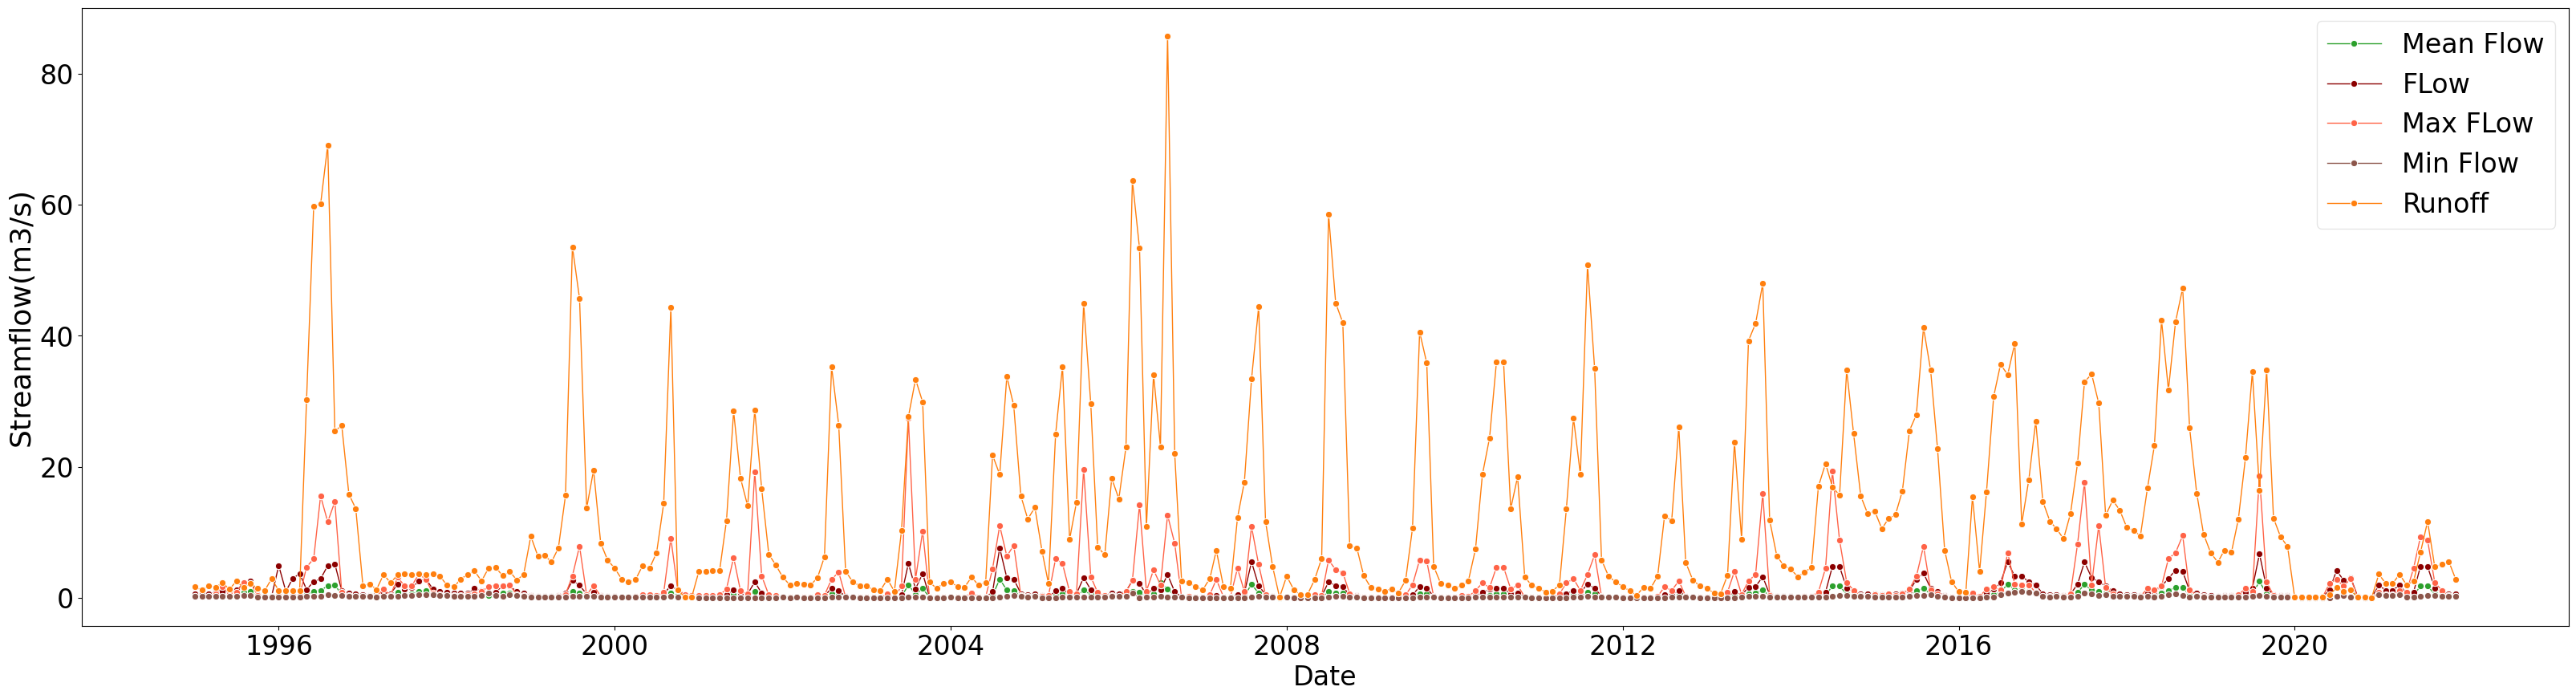

In [249]:
parameters = transformed_data['Parameter'].unique()

custom_colors = {
    parameters[0]: '#2ca02c',
    parameters[1]: '#8b0000',
    parameters[2]: '#ff6347',
    parameters[3]: '#8c564b',
    parameters[4]: '#ff7f0e',
}

plt.figure(figsize=(40, 10))

for parameter in parameters:
    parameter_data = transformed_data[transformed_data['Parameter'] == parameter]
    parameter_data.set_index('Date', inplace=True)
    sns.lineplot(data=parameter_data,
                 x=parameter_data.index,
                 y='Value',
                 marker='o',
                 label=parameter,
                 linewidth=1,
                 color=custom_colors[parameter])

# plt.title('Monthly Analysis', fontsize=24)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Streamflow(m3/s)', fontsize=26)
plt.legend(loc='best', fontsize=24, framealpha=0.5)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

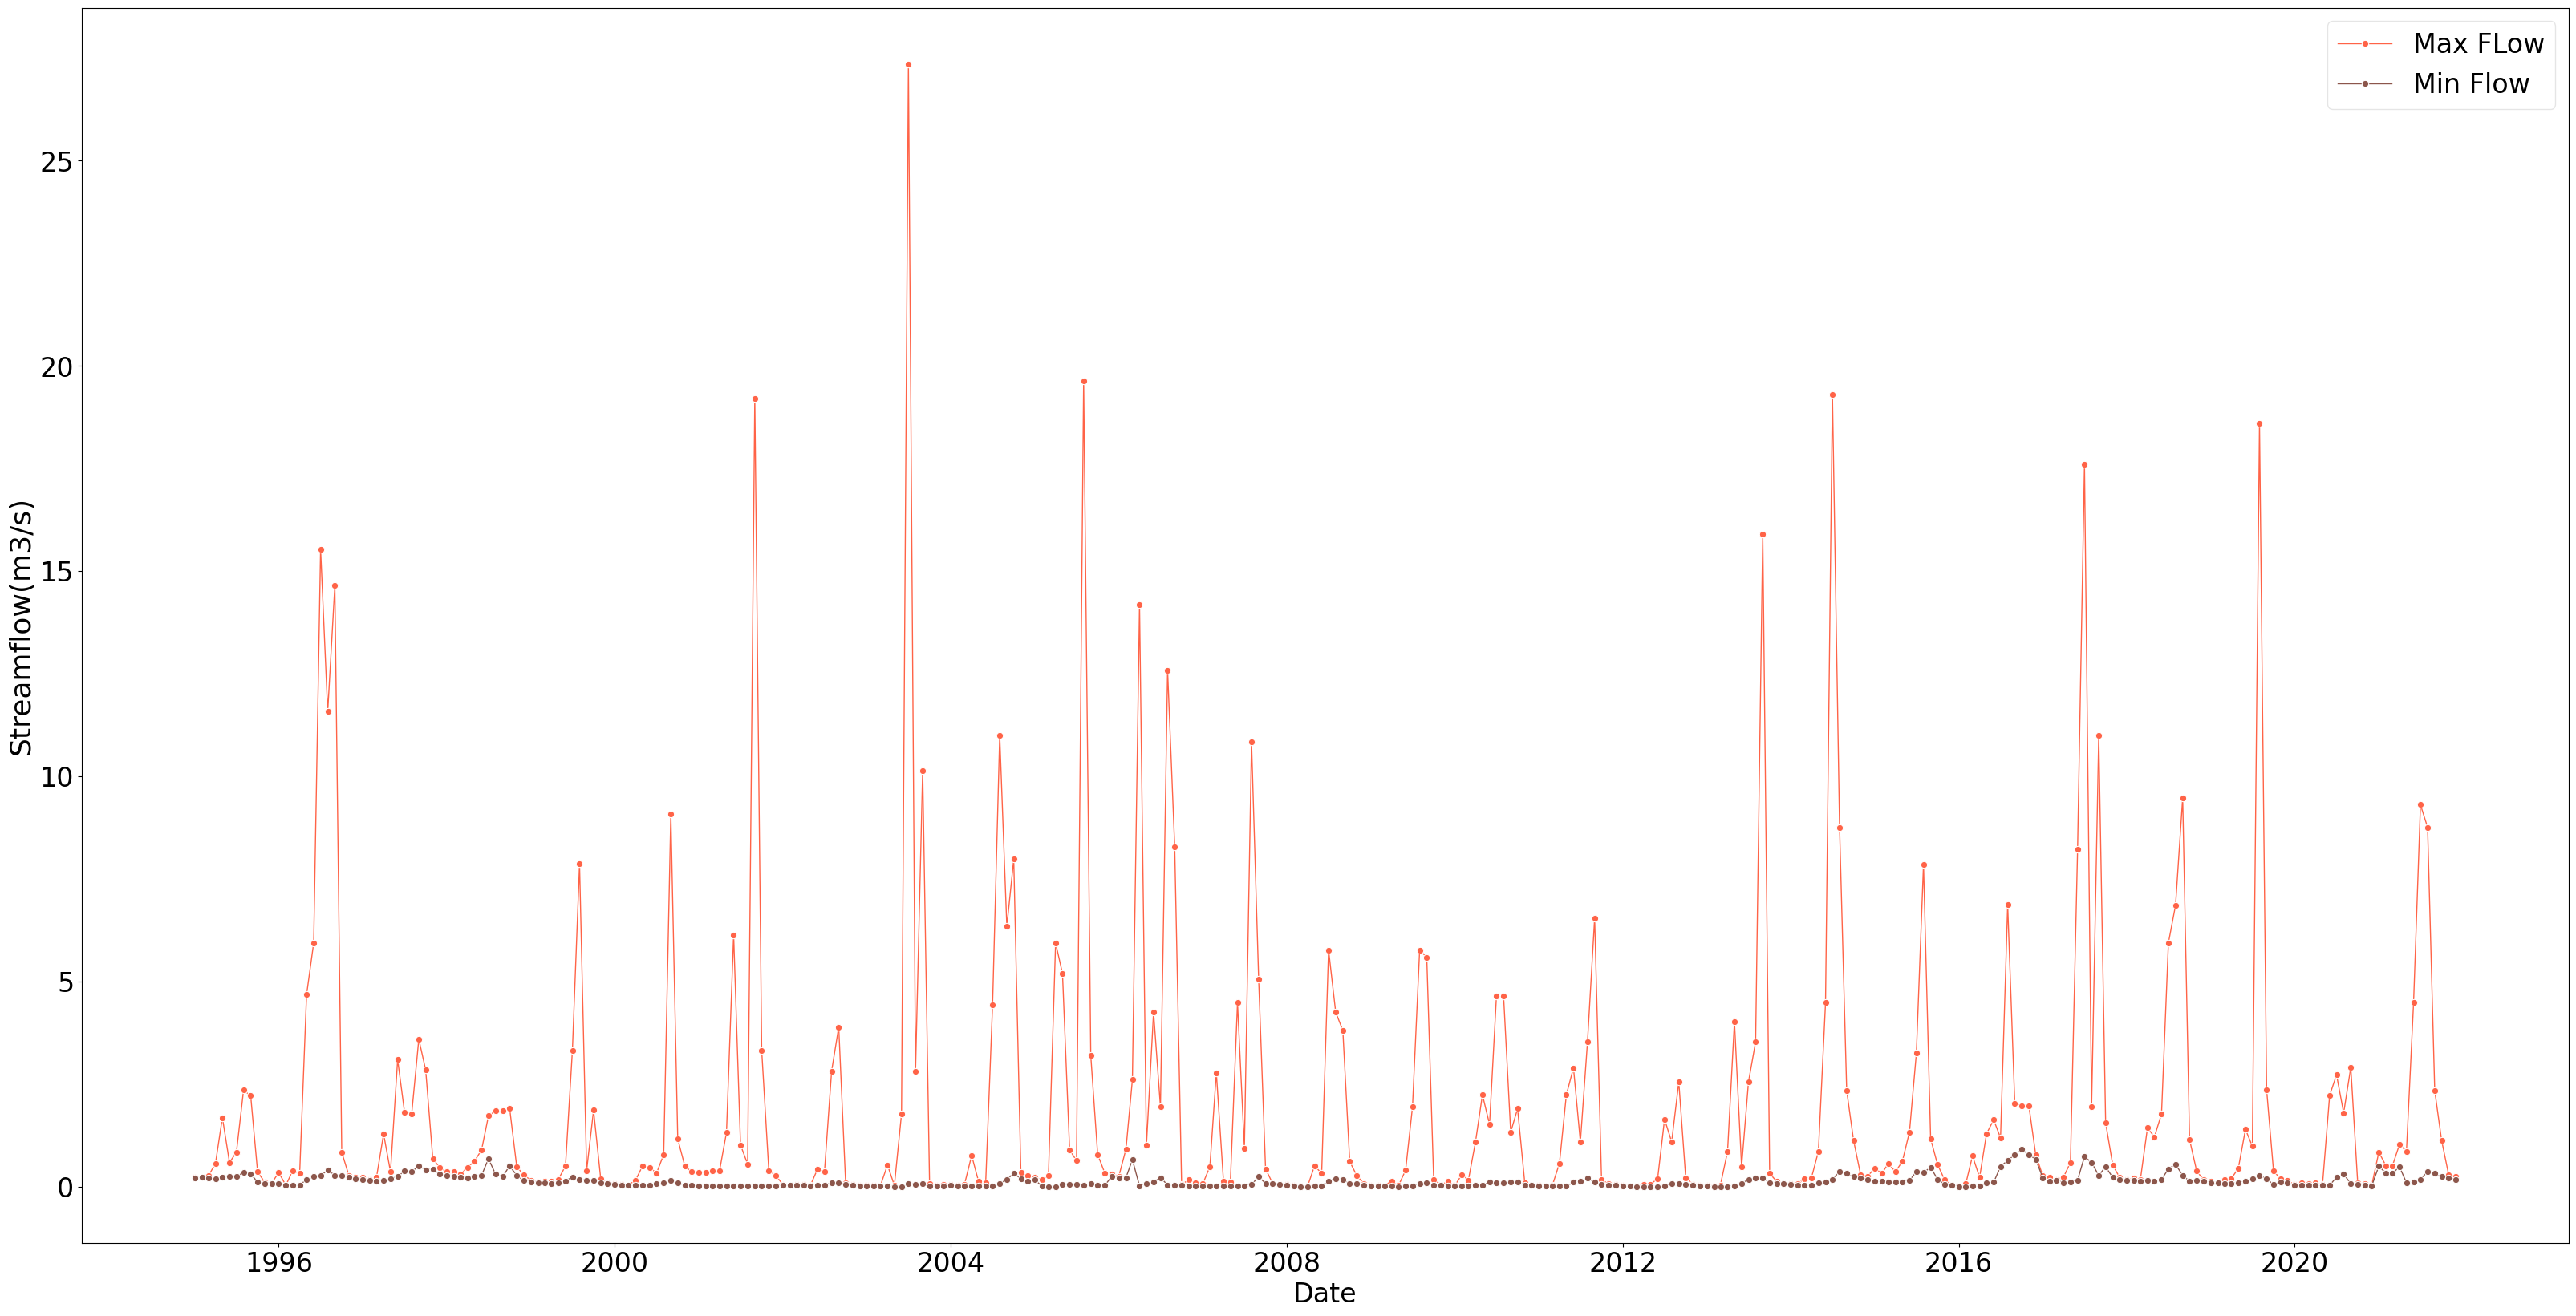

In [250]:
parameters = transformed_data['Parameter'].unique()

custom_colors = {
    # parameters[0]: '#2ca02c',
    # parameters[1]: '#8b0000',
    parameters[2]: '#ff6347',
    parameters[3]: '#8c564b',
    # parameters[4]: '#ff7f0e',
}

plt.figure(figsize=(40, 20))

for parameter in parameters[2:4]:
    parameter_data = transformed_data[transformed_data['Parameter'] == parameter]
    parameter_data.set_index('Date', inplace=True)
    sns.lineplot(data=parameter_data,
                 x=parameter_data.index,
                 y='Value',
                 marker='o',
                 label=parameter,
                 linewidth=1,
                 color=custom_colors[parameter])

# plt.title('Monthly Analysis', fontsize=24)
plt.xlabel('Date', fontsize=24)
plt.ylabel('Streamflow(m3/s)', fontsize=26)
plt.legend(loc='best', fontsize=24, framealpha=0.5)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.show()

In [251]:
parameters = transformed_data['Parameter'].unique()
parameters

array(['Mean Flow', 'FLow', 'Max FLow', 'Min Flow', 'Runoff'],
      dtype=object)

## 5. FIND THE CORRELATIONS BETWEEN EACH PARAMETERS

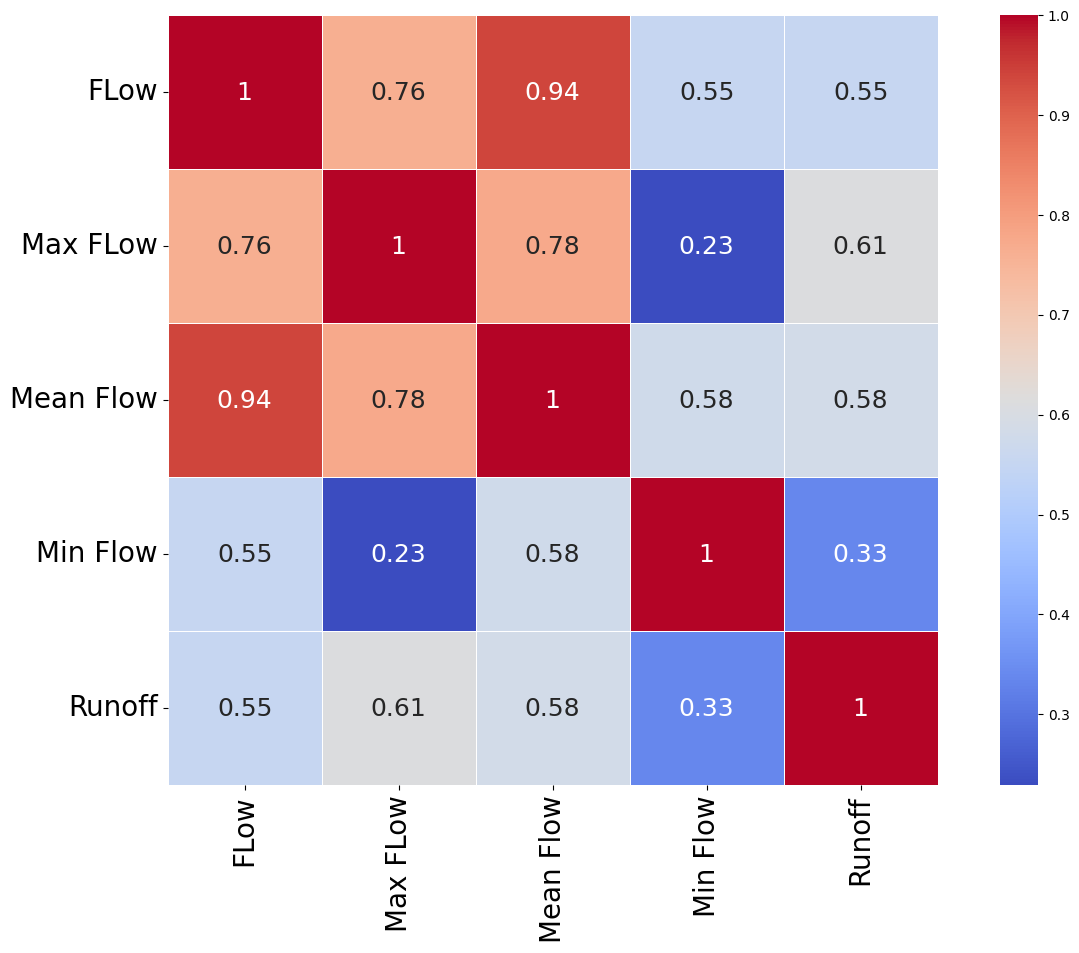

In [252]:
transformed_data = transformed_data.drop_duplicates(subset=['Date', 'Parameter'])

# Pivot the data
pivot_data = transformed_data.pivot(index='Date', columns='Parameter', values='Value')

# Calculate the correlation matrix
correlation_matrix = pivot_data.corr()

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, linewidths=0.5, annot_kws={"size": 18})

# Adjust x-tick and y-tick labels rotation
plt.xticks(rotation=90, fontsize=20)
plt.yticks(rotation=0, fontsize=20)

plt.xlabel('')
plt.ylabel('')
plt.show()


## 6. COMMON FUNCTION

### TIME SERIES TO SUPERVISED

In [253]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = pd.concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

### ADD ROLLING FEATURES

In [254]:
def add_rolling_features(data, window=3):
    df = pd.DataFrame(data)
    df['rolling_mean'] = df.iloc[:, 0].rolling(window=window).mean()
    df['rolling_std'] = df.iloc[:, 0].rolling(window=window).std()
    df.dropna(inplace=True)
    return df

### TRAIN TEST SPLITT

In [255]:
def train_test_split(data, train_size=0.9):
    n_train = int(len(data) * train_size)
    return data[:n_train], data[n_train:]

### MEASURING METRICS

In [256]:
def nash_sutcliffe_efficiency(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
def willmotts_index(y_true, y_pred):
    return 1 - (np.sum((y_pred - y_true)**2) / np.sum((np.abs(y_pred - np.mean(y_true)) + np.abs(y_true - np.mean(y_true)))**2))


### CROSS VALIDATION AND MODEL EVALUATIONS

In [257]:
def walk_forward_validation(data, model):
    predictions = []
    train, test = train_test_split(data)
    history = [x for x in train.values]
    for i in range(len(test)):
        testX, testy = test.iloc[i, :-1].values, test.iloc[i, -1]
        yhat = model(history, testX)
        predictions.append(yhat)
        history.append(test.iloc[i].values)
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    mae = mean_absolute_error(test.iloc[:, -1], predictions)
    rmse = np.sqrt(np.mean((test.iloc[:, -1] - np.asarray(predictions))**2))
    r2 = r2_score(test.iloc[:, -1], predictions)
    nse = nash_sutcliffe_efficiency(test.iloc[:, -1], predictions)
    willmott = willmotts_index(test.iloc[:, -1], predictions)
    return mae, rmse, r2, nse, willmott, test.index, test.iloc[:, -1], predictions

## 7. MODELS


### 1. RANDOM FOREST

In [258]:
def random_forest_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = RandomForestRegressor(n_estimators=50)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]

### 2. SVM

In [259]:
from sklearn.svm import SVR
def svm_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = SVR(kernel='rbf')
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]


### 3. XGBRegressor

In [260]:
from xgboost import XGBRegressor
def xgboost_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = XGBRegressor(n_estimators=50)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]


### 4. LGBMRegressor


In [261]:
from lightgbm import LGBMRegressor
def lightgbm_forecast(train, testX):
    train = np.asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]
    model = LGBMRegressor(n_estimators=50, verbose=-1)
    model.fit(trainX, trainy)
    yhat = model.predict([testX])
    return yhat[0]


In [262]:
# Color dictionary for different models
colors_dict = {
    'LightGBM': '#27ad81',
    'XGBoost': '#5dc863',
    'SVM': '#aadc32',
    'Random Forest': '#fde725'
}

## 6. MEAN FLOW ANALYSIS

In [263]:
# Get the mean flow values
mean_flow = transformed_data[transformed_data['Parameter'] == parameters[0]]
mean_flow.head()

Parameter       Date     Value
0   Mean Flow 1995-01-01  0.224000
5   Mean Flow 1996-01-01  0.163161
10  Mean Flow 1997-01-01  0.181000
15  Mean Flow 1998-01-01  0.295000
20  Mean Flow 1999-01-01  0.144000

In [264]:
# drop the parameter columns
mean_flow = mean_flow.drop(columns=['Parameter'])

In [265]:
mean_flow.head()

Date     Value
0  1995-01-01  0.224000
5  1996-01-01  0.163161
10 1997-01-01  0.181000
15 1998-01-01  0.295000
20 1999-01-01  0.144000

In [266]:
# sort according to  the date
mean_flow= mean_flow.sort_values(by='Date')
mean_flow.head()

Date  Value
0   1995-01-01  0.224
135 1995-02-01  0.223
270 1995-03-01  0.227
405 1995-04-01  0.309
540 1995-05-01  0.341

In [267]:
mean_flow.head()

Date  Value
0   1995-01-01  0.224
135 1995-02-01  0.223
270 1995-03-01  0.227
405 1995-04-01  0.309
540 1995-05-01  0.341

In [268]:
# Find the row with the maximum value
max_value_row = mean_flow.loc[mean_flow['Value'].idxmax()]

# Print the date with the maximum value
print(f"Date with the maximum value: {mean_flow['Date']}")
print(f"Maximum value: {max_value_row['Value']}")

Date with the maximum value: 0      1995-01-01
135    1995-02-01
270    1995-03-01
405    1995-04-01
540    1995-05-01
          ...    
1075   2021-08-01
1210   2021-09-01
1345   2021-10-01
1480   2021-11-01
1615   2021-12-01
Name: Date, Length: 324, dtype: datetime64[ns]
Maximum value: 2.829


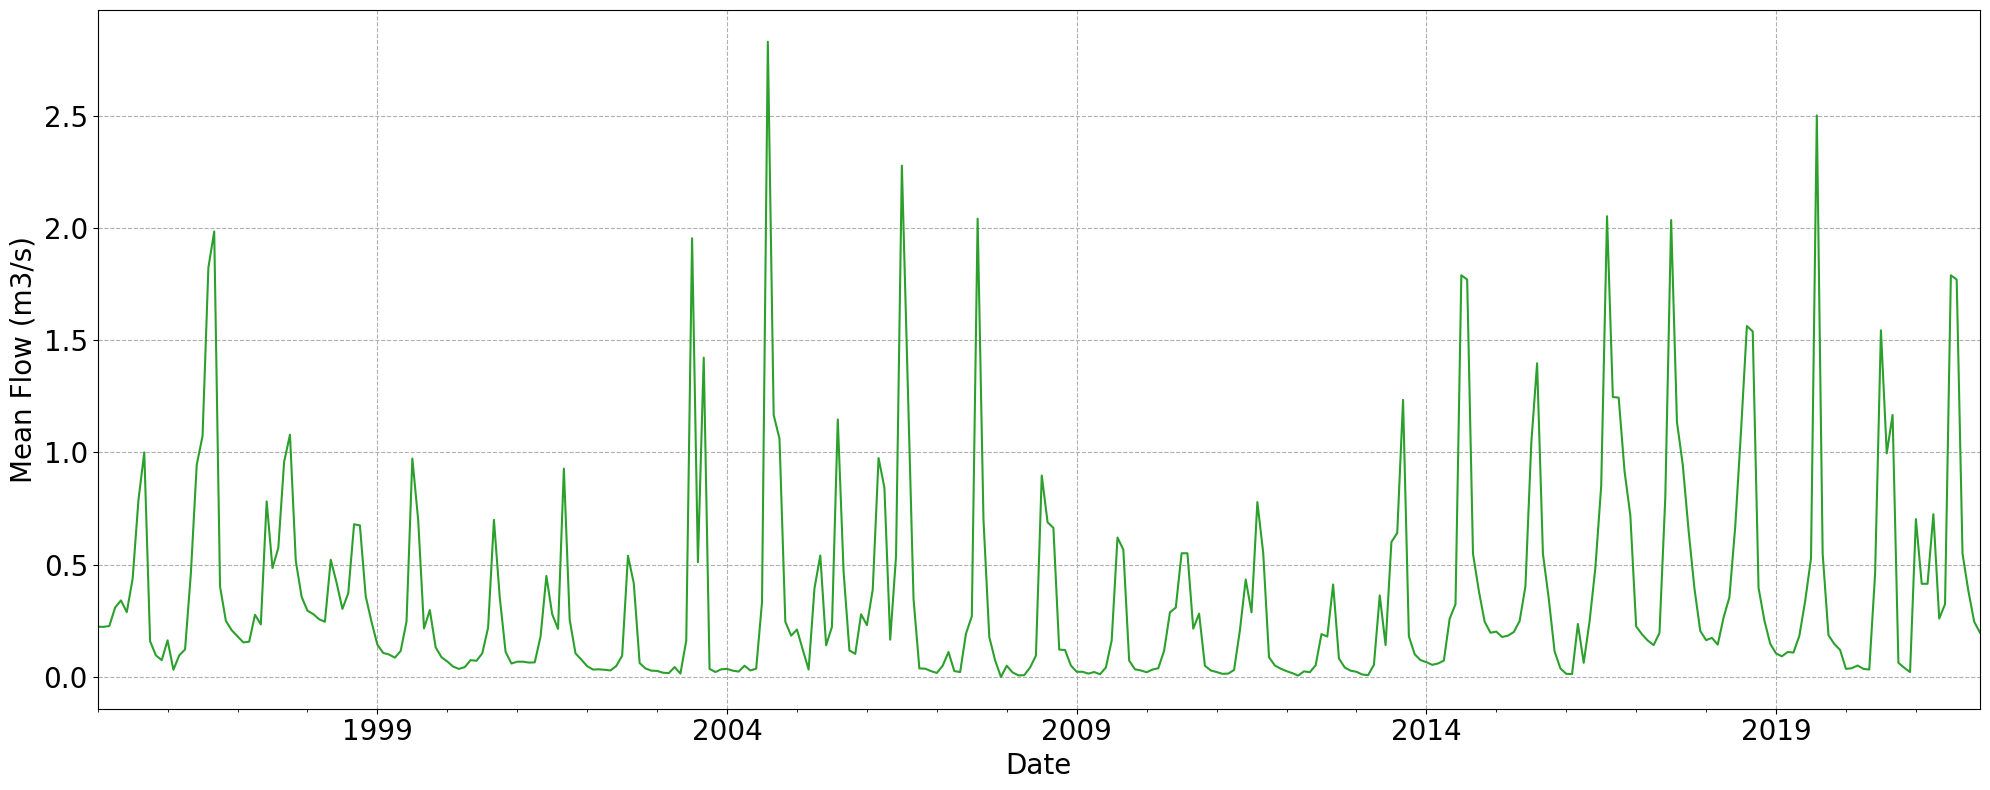

In [269]:
plt.figure(figsize=(20, 8))
mean_flow.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#2ca02c', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Mean Flow (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [270]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [271]:
# H0: It is non stationary
# H1: It is stationary

In [272]:
adfuller_test(mean_flow['Value'])

ADF Test Statistic : -2.4945372082496937
p-value : 0.11680914517324759
#Lags Used : 13
Number of Observations Used : 310
Weak evidence against the null hypothesis(H0)


In [273]:
mean_flow = mean_flow[['Date', 'Value']]
mean_flow.set_index('Date', inplace=True)
mean_flow.head()

Value
Date             
1995-01-01  0.224
1995-02-01  0.223
1995-03-01  0.227
1995-04-01  0.309
1995-05-01  0.341

In [274]:
model_names = []
mae_values = []
rmse_values = []
r2_values = []
nse_values = []
willmott_values = []

### TRAIN THE MODEL

In [275]:
# Assuming `mean flow` is your time series DataFrame
series = mean_flow
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=-0.7, predicted=-0.6
>expected=-0.4, predicted=-0.5
>expected=-0.2, predicted=0.0
>expected=3.4, predicted=1.9
>expected=3.2, predicted=2.0
>expected=3.6, predicted=2.0
>expected=-0.0, predicted=-0.0
>expected=-0.7, predicted=-0.5
>expected=-0.6, predicted=-0.8
>expected=-0.7, predicted=-0.7
>expected=-0.8, predicted=-0.7
>expected=-0.8, predicted=-0.8
>expected=-0.8, predicted=-0.8
>expected=0.0, predicted=-0.2
>expected=1.9, predicted=1.6
>expected=1.1, predicted=2.5
>expected=0.2, predicted=1.6
>expected=1.3, predicted=0.6
>expected=1.4, predicted=0.7
>expected=-0.8, predicted=-0.8
>expected=0.5, predicted=-0.0
>expected=0.4, predicted=-0.0
>expected=-0.2, predicted=0.4
>expected=-0.2, predicted=0.0
>expected=0.0, predicted=-0.2
>expected=0.1, predicted=0.0
>expected=2.2, predicted=1.9
>expected=2.1, predicted=2.3
>expected=1.7, predicted=1.9
>expected=1.8, predicted=1.8
>expected=-0.3, predicted=-0.3
>expected=-0.5, predicted=-0.5
>expected=-0.7, predicted=-0.7
>expected=

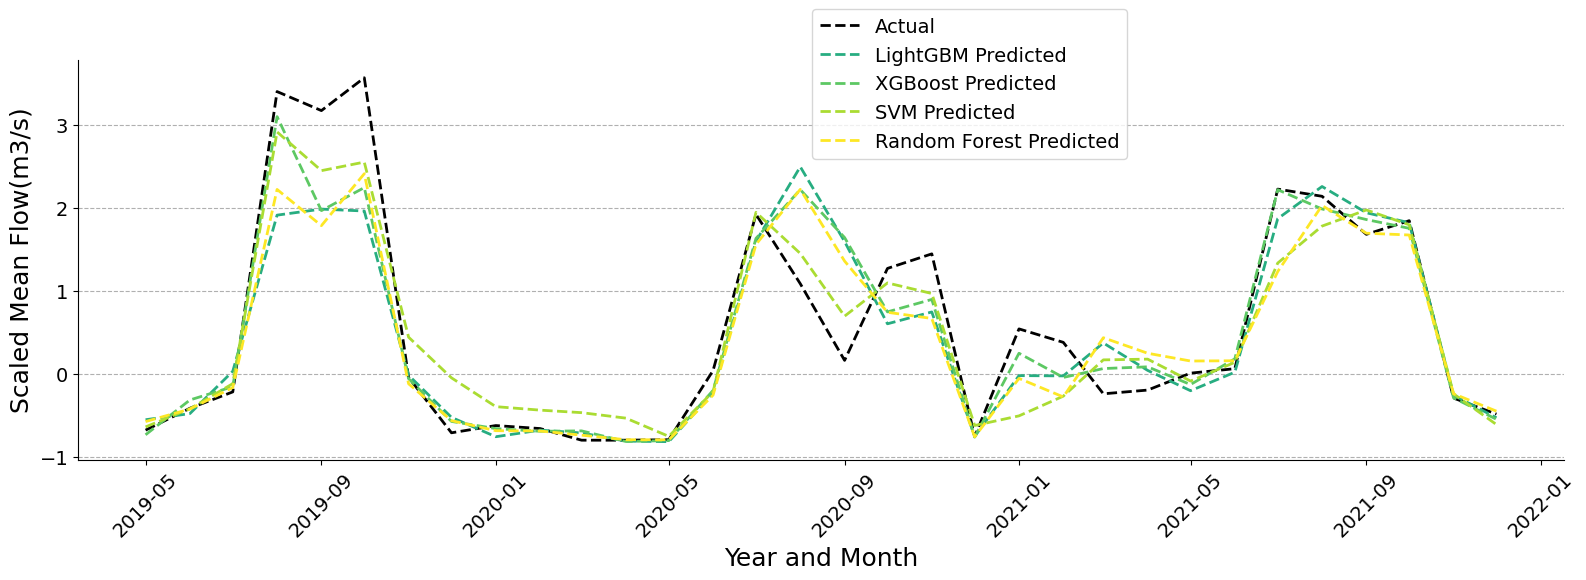

In [276]:
# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)


# Plot predictions for each model
for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Mean Flow(m3/s)', fontsize=18)
plt.legend(fontsize=14, loc='upper center', bbox_to_anchor=(0.6, 1.15), ncol=1)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [277]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [278]:
metrics

Model       MAE      RMSE  R-squared  Nash-Sutcliffe Efficiency  \
0       LightGBM  0.403790  0.629322   0.768773                   0.768773   
1        XGBoost  0.302683  0.502463   0.852598                   0.852598   
2            SVM  0.343343  0.446910   0.883390                   0.883390   
3  Random Forest  0.380600  0.584901   0.800263                   0.800263   

   Willmott's Index of Agreement  
0                       0.927839  
1                       0.957353  
2                       0.964259  
3                       0.937047

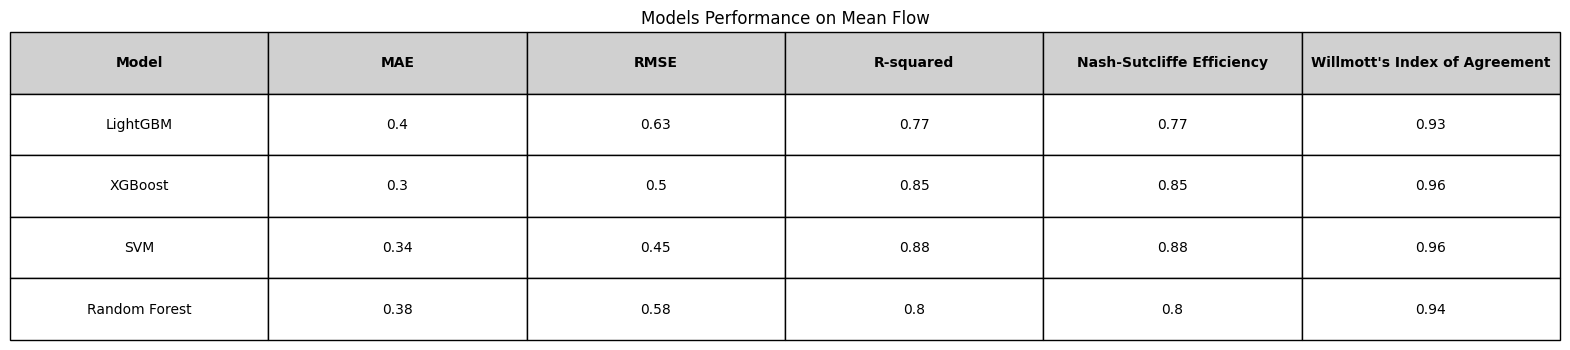

In [279]:
metrics = metrics.round(2)
fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Mean Flow')
plt.show()


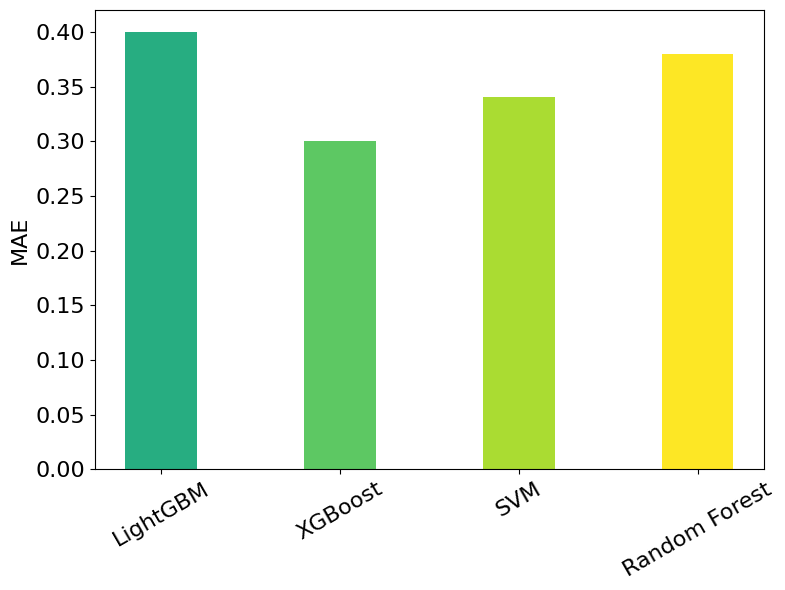

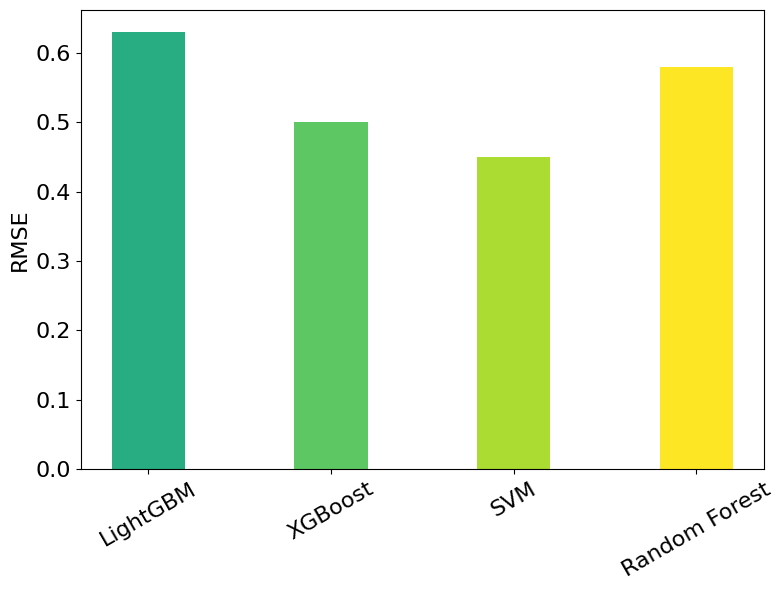

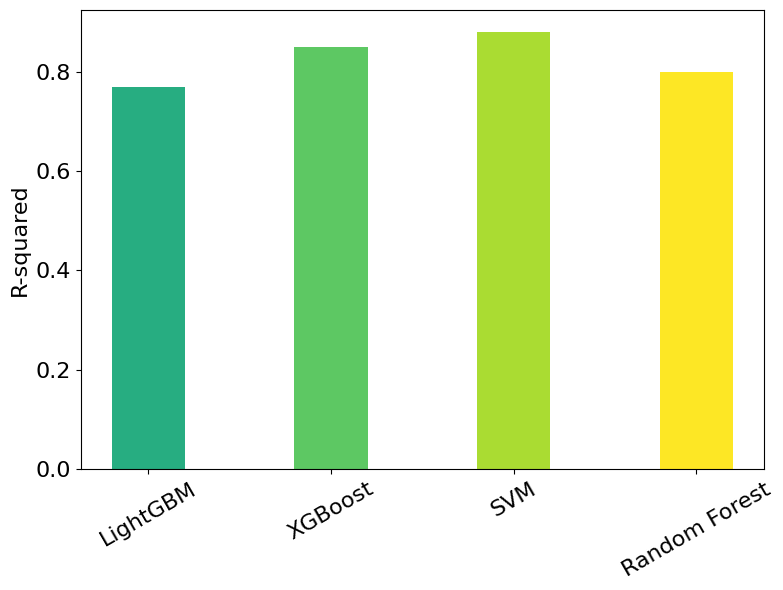

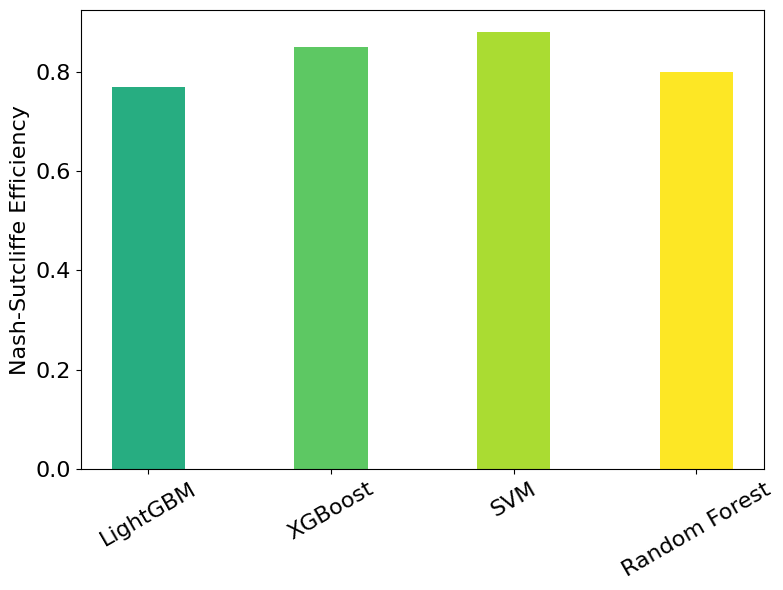

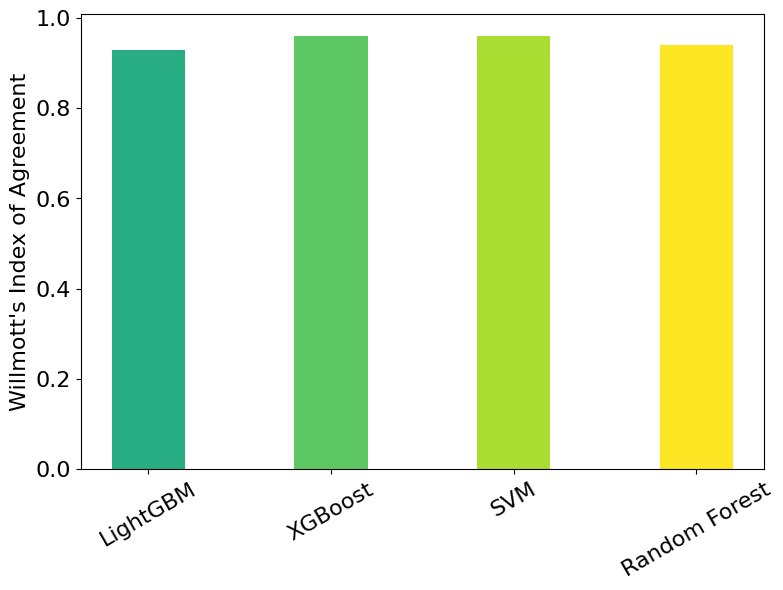

In [280]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()


## 7. FLOW ANALYSIS

In [281]:
# Get the temp_max values
flow = transformed_data[transformed_data['Parameter'] == parameters[1]]
flow.head()

Parameter       Date    Value
1       FLow 1995-01-01  0.60100
6       FLow 1996-01-01  4.89483
11      FLow 1997-01-01  0.48600
16      FLow 1998-01-01  0.79000
21      FLow 1999-01-01  0.38500

In [282]:
# drop the parameter columns
flow = flow.drop(columns=['Parameter'])

In [283]:
flow.head()

Date    Value
1  1995-01-01  0.60100
6  1996-01-01  4.89483
11 1997-01-01  0.48600
16 1998-01-01  0.79000
21 1999-01-01  0.38500

In [284]:
# sort according to  the date
flow= flow.sort_values(by='Date')
flow.head()

Date  Value
1   1995-01-01  0.601
136 1995-02-01  0.539
271 1995-03-01  0.609
406 1995-04-01  0.802
541 1995-05-01  0.914

In [285]:
flow.head()

Date  Value
1   1995-01-01  0.601
136 1995-02-01  0.539
271 1995-03-01  0.609
406 1995-04-01  0.802
541 1995-05-01  0.914

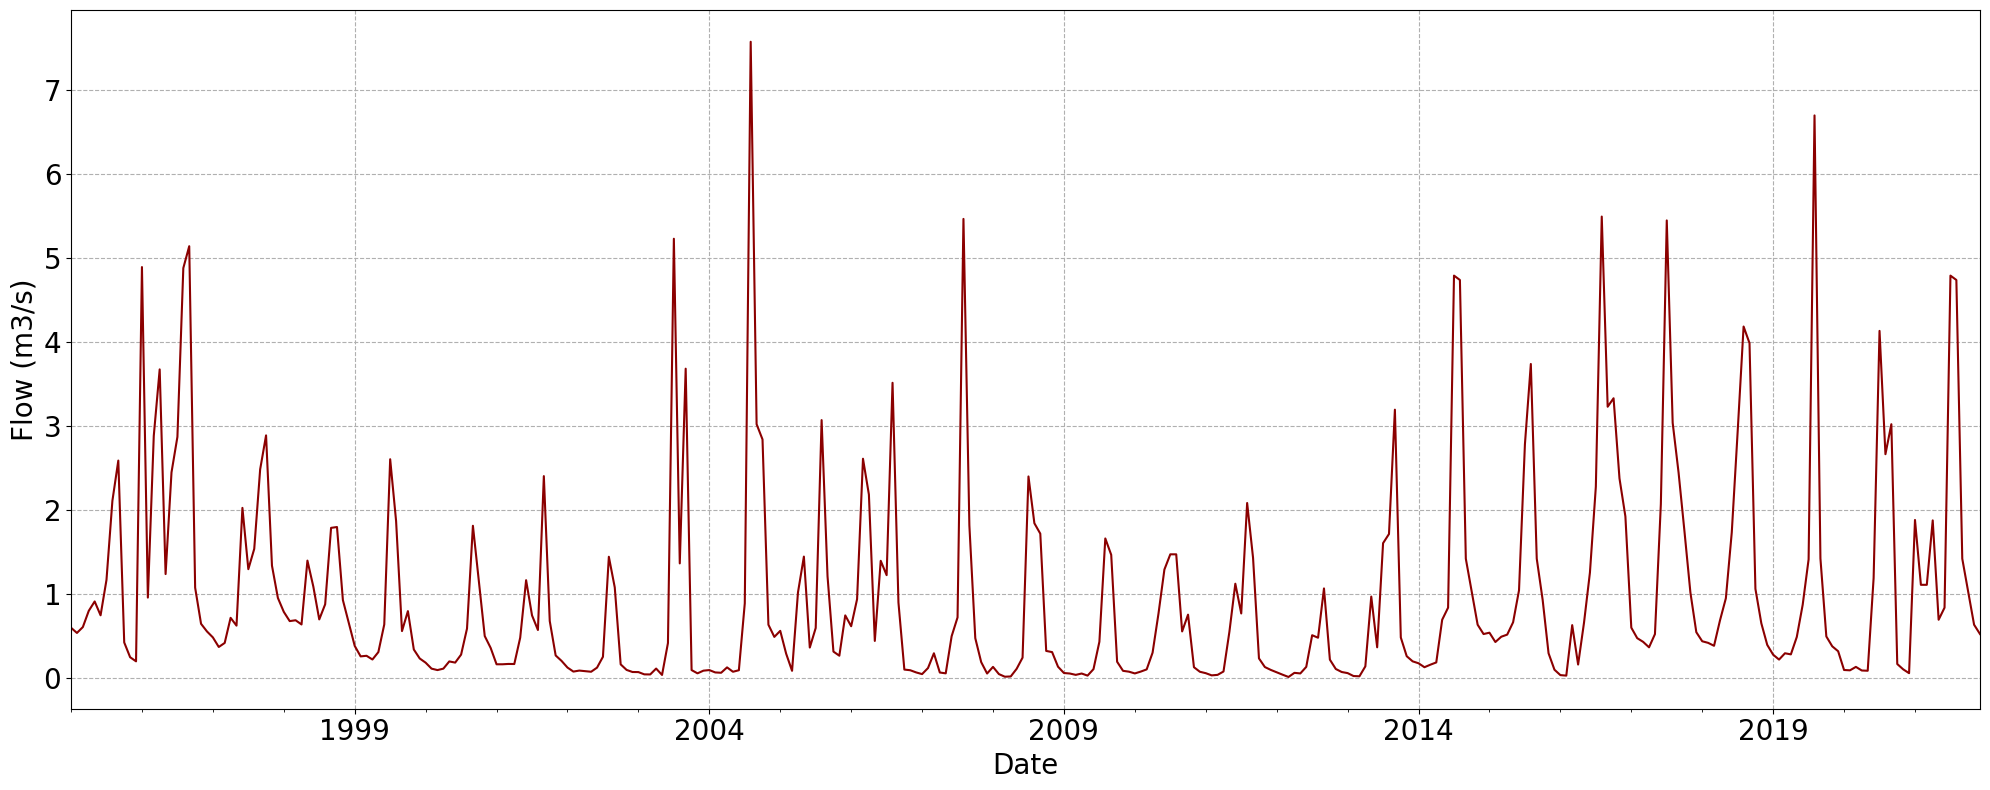

In [286]:

plt.figure(figsize=(20, 8))
flow.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#8b0000', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Flow (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [287]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [288]:
# H0: It is non stationary
# H1: It is stationary

In [289]:
adfuller_test(flow['Value'])

ADF Test Statistic : -2.592225967325901
p-value : 0.09461467042325716
#Lags Used : 13
Number of Observations Used : 310
Weak evidence against the null hypothesis(H0)


In [290]:
flow = flow[['Date', 'Value']]
flow.set_index('Date', inplace=True)
flow.head()

Value
Date             
1995-01-01  0.601
1995-02-01  0.539
1995-03-01  0.609
1995-04-01  0.802
1995-05-01  0.914

In [291]:
flow_model_names = []
flow_mae_values = []
flow_rmse_values = []
flow_r2_values = []
flow_nse_values = []
flow_willmott_values = []

### TRAIN THE MODELS

In [292]:
# Assuming `temp_max` is your time series DataFrame
series = flow
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=-0.7, predicted=-0.6
>expected=-0.4, predicted=-0.6
>expected=-0.2, predicted=0.0
>expected=3.4, predicted=2.0
>expected=3.2, predicted=1.7
>expected=3.6, predicted=1.9
>expected=-0.1, predicted=-0.1
>expected=-0.7, predicted=-0.6
>expected=-0.6, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.8, predicted=-0.8
>expected=-0.8, predicted=-0.8
>expected=-0.8, predicted=-0.8
>expected=-0.0, predicted=-0.2
>expected=1.9, predicted=2.0
>expected=1.1, predicted=2.6
>expected=0.2, predicted=1.8
>expected=1.2, predicted=0.7
>expected=1.4, predicted=0.7
>expected=-0.8, predicted=-0.7
>expected=0.5, predicted=0.0
>expected=0.4, predicted=-0.0
>expected=-0.3, predicted=0.4
>expected=-0.3, predicted=-0.2
>expected=-0.0, predicted=-0.2
>expected=0.0, predicted=0.1
>expected=2.2, predicted=1.8
>expected=2.2, predicted=2.0
>expected=1.7, predicted=1.9
>expected=1.9, predicted=1.7
>expected=-0.3, predicted=-0.1
>expected=-0.5, predicted=-0.6
>expected=-0.7, predicted=-0.7
>expecte

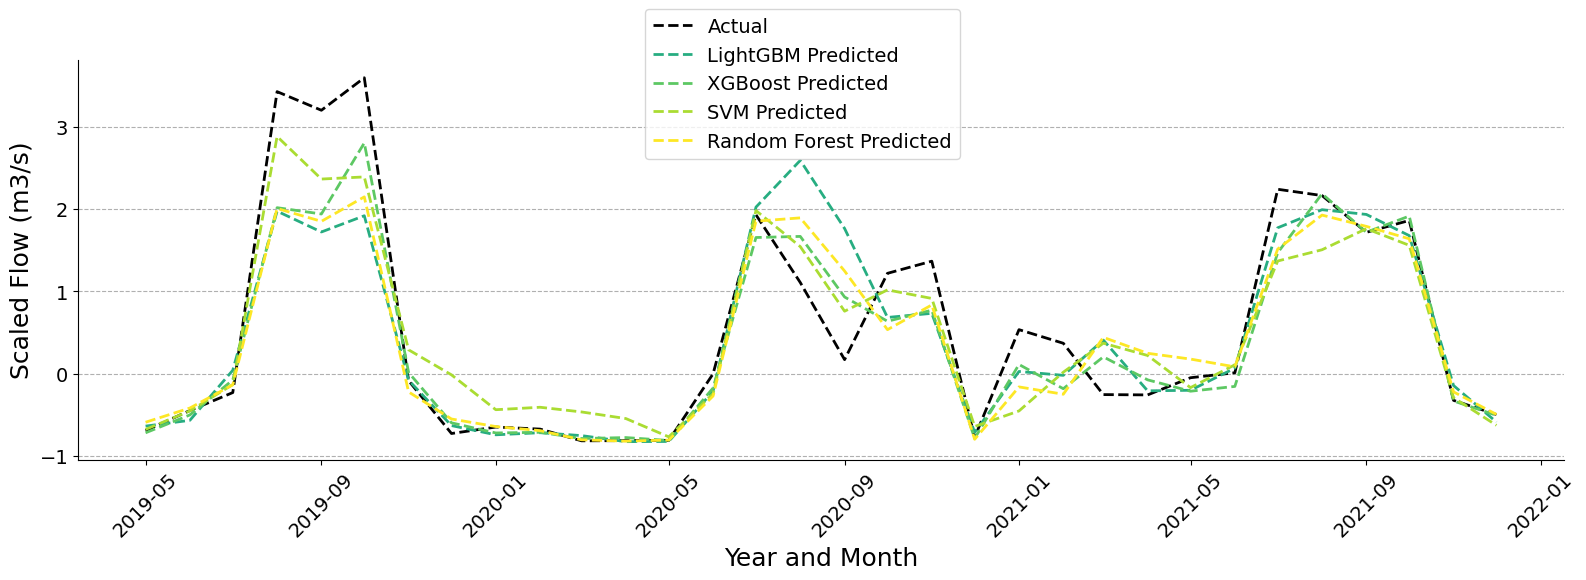

In [293]:

# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Flow (m3/s)', fontsize=18)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.6, 1.15), ncol=1)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [294]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [295]:
metrics

Model       MAE      RMSE  R-squared  Nash-Sutcliffe Efficiency  \
0       LightGBM  0.409872  0.660180   0.751504                   0.751504   
1        XGBoost  0.308311  0.478650   0.869374                   0.869374   
2            SVM  0.366457  0.478225   0.869605                   0.869605   
3  Random Forest  0.359409  0.548506   0.828463                   0.828463   

   Willmott's Index of Agreement  
0                       0.921768  
1                       0.959671  
2                       0.958244  
3                       0.944408

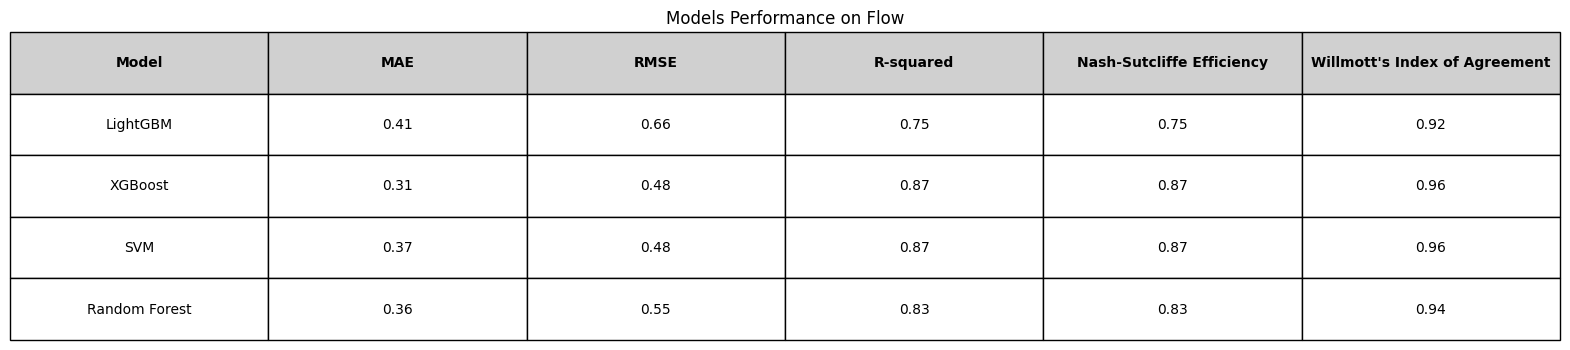

In [296]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Flow')
plt.show()


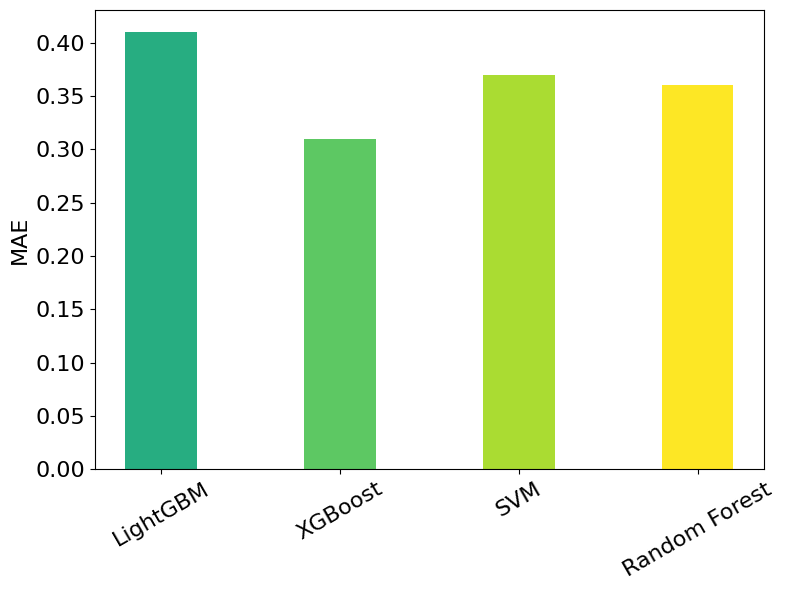

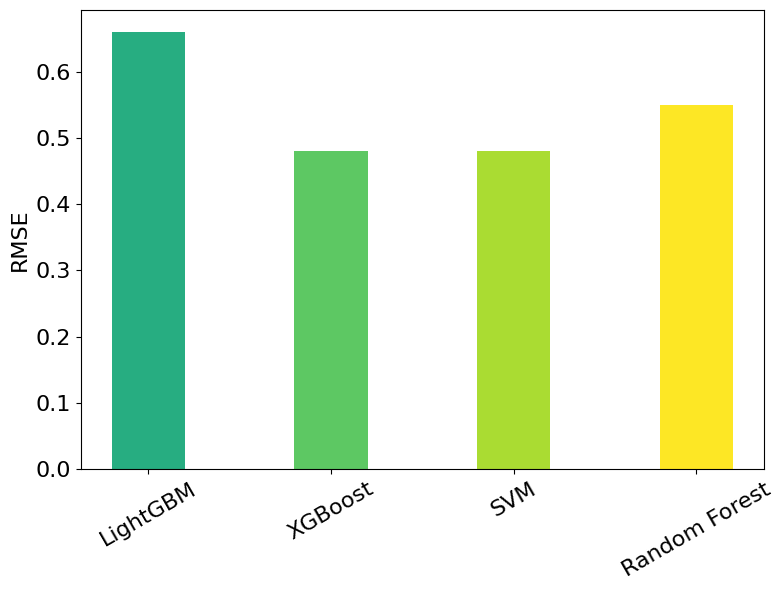

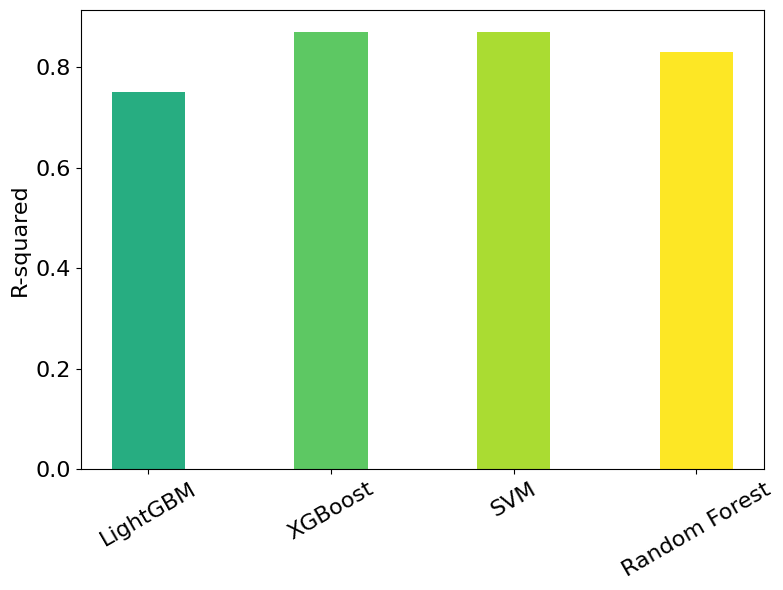

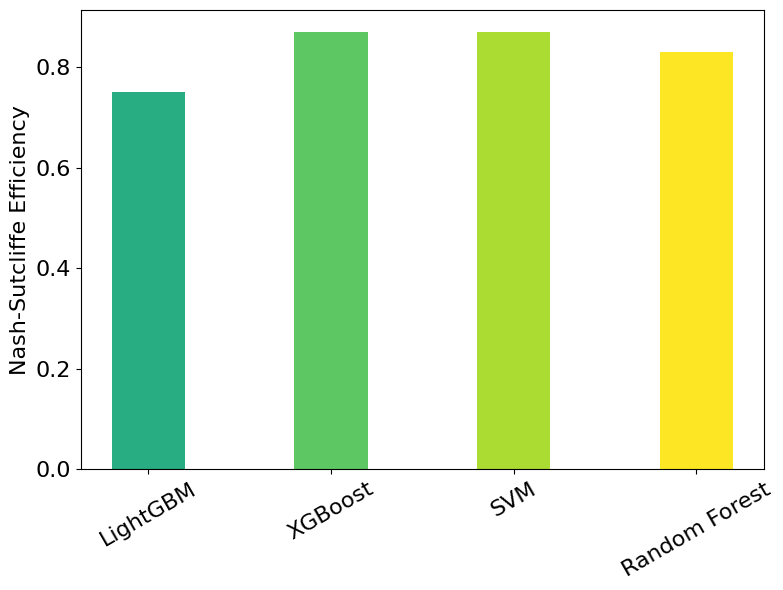

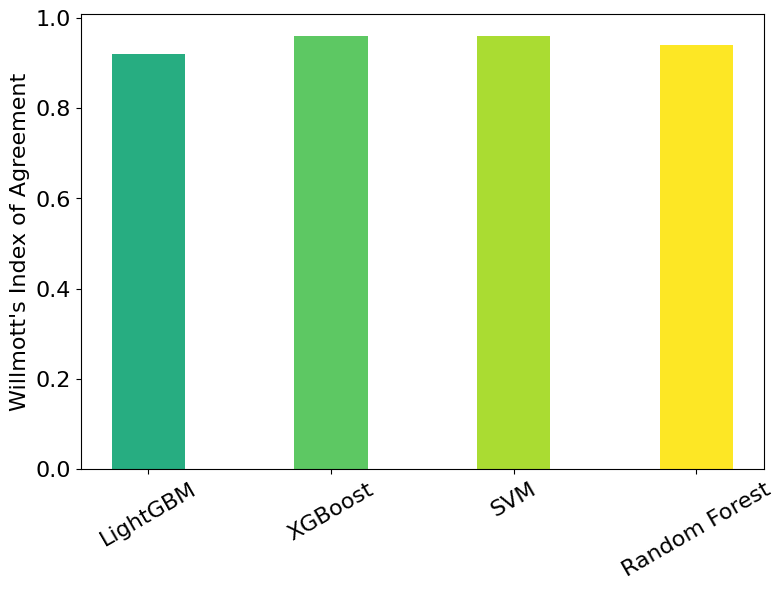

In [297]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

## 8. MAX FLOW ANALYSIS

In [298]:
# Get the temp_max values
flow_max = transformed_data[transformed_data['Parameter'] == parameters[2]]
flow_max.head()

Parameter       Date  Value
2   Max FLow 1995-01-01  0.235
7   Max FLow 1996-01-01  0.345
12  Max FLow 1997-01-01  0.223
17  Max FLow 1998-01-01  0.362
22  Max FLow 1999-01-01  0.159

In [299]:
# drop the parameter columns
flow_max = flow_max.drop(columns=['Parameter'])

In [300]:
flow_max.head()

Date  Value
2  1995-01-01  0.235
7  1996-01-01  0.345
12 1997-01-01  0.223
17 1998-01-01  0.362
22 1999-01-01  0.159

In [301]:
# sort according to  the date
flow_max= flow_max.sort_values(by='Date')
flow_max.head()

Date  Value
2   1995-01-01  0.235
137 1995-02-01  0.223
272 1995-03-01  0.260
407 1995-04-01  0.569
542 1995-05-01  1.683

In [302]:
flow_max.head()

Date  Value
2   1995-01-01  0.235
137 1995-02-01  0.223
272 1995-03-01  0.260
407 1995-04-01  0.569
542 1995-05-01  1.683

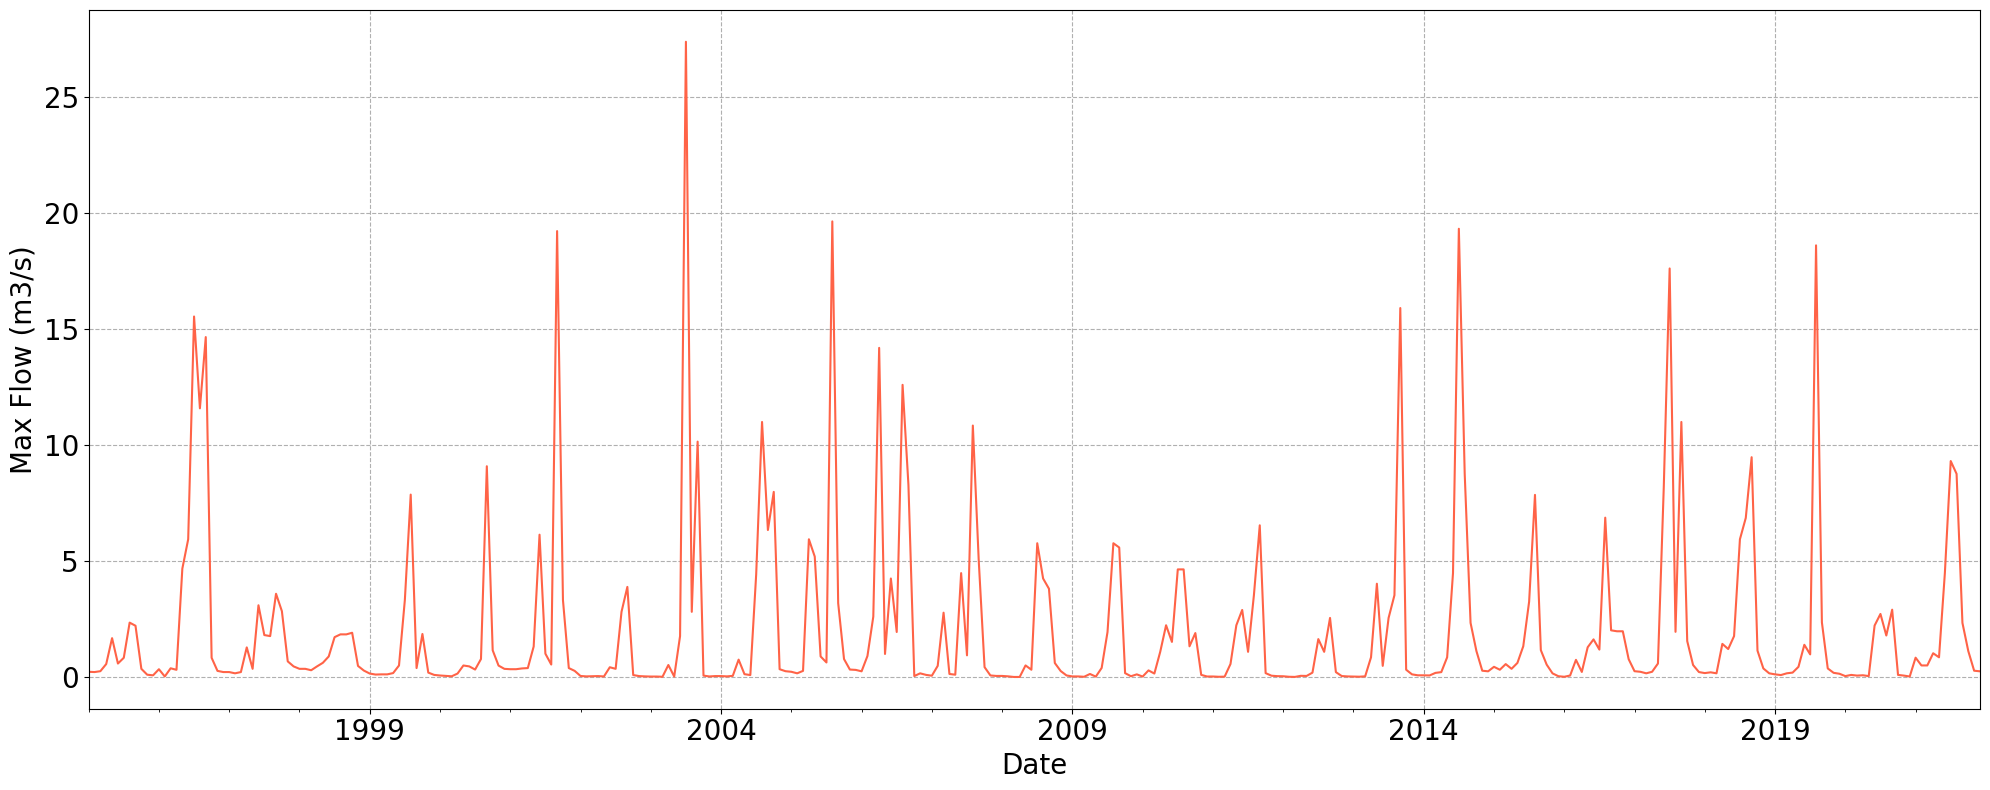

In [303]:
plt.figure(figsize=(20, 8))
flow_max.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#ff6347', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Max Flow (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [304]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [305]:
# H0: It is non stationary
# H1: It is stationary

In [306]:
adfuller_test(flow_max['Value'])

ADF Test Statistic : -4.083392870423538
p-value : 0.001031585994254914
#Lags Used : 13
Number of Observations Used : 310
Strong evidence against the null hypothesis(H0)


In [307]:
flow_max = flow_max[['Date', 'Value']]
flow_max.set_index('Date', inplace=True)
flow_max.head()

Value
Date             
1995-01-01  0.235
1995-02-01  0.223
1995-03-01  0.260
1995-04-01  0.569
1995-05-01  1.683

In [308]:
flow_max_model_names = []
flow_max_mae_values = []
flow_max_rmse_values = []
flow_max_r2_values = []
flow_max_nse_values = []
flow_max_willmott_values = []

### TRAIN THE MODEL

In [309]:
# Assuming `flow_max` is your time series DataFrame
series = flow_max
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=-0.6, predicted=-0.6
>expected=-0.5, predicted=-0.5
>expected=-0.5, predicted=-0.4
>expected=3.0, predicted=2.3
>expected=2.9, predicted=2.7
>expected=3.0, predicted=2.7
>expected=-0.2, predicted=0.1
>expected=-0.6, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.7, predicted=-0.7
>expected=-0.2, predicted=-0.3
>expected=-0.2, predicted=-0.2
>expected=-0.5, predicted=-0.3
>expected=-0.5, predicted=-0.5
>expected=-0.2, predicted=-0.3
>expected=-0.1, predicted=-0.1
>expected=-0.7, predicted=-0.6
>expected=-0.5, predicted=-0.6
>expected=-0.5, predicted=-0.6
>expected=-0.6, predicted=-0.5
>expected=-0.6, predicted=-0.5
>expected=-0.6, predicted=-0.4
>expected=0.1, predicted=0.1
>expected=0.9, predicted=0.6
>expected=0.3, predicted=1.2
>expected=0.7, predicted=1.4
>expected=0.8, predicted=0.9
>expected=-0.3, predicted=-0.4
>expected=-0.5, predicted=-0.5
>expected=-0.6, predicted

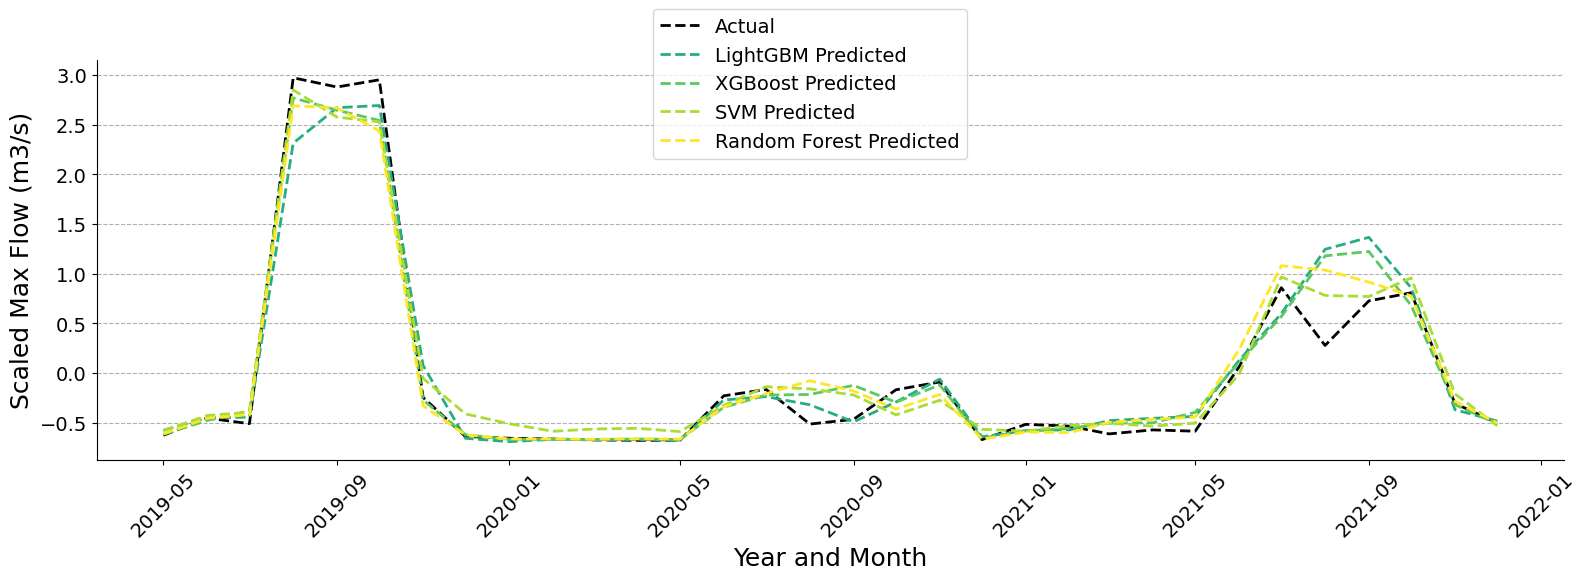

In [310]:
# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)

for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Max Flow (m3/s)', fontsize=18)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.6, 1.15), ncol=1)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y', linestyle='--')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [311]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [312]:
metrics

Model       MAE      RMSE  R-squared  Nash-Sutcliffe Efficiency  \
0       LightGBM  0.147210  0.262236   0.935964                   0.935964   
1        XGBoost  0.137944  0.233216   0.949353                   0.949353   
2            SVM  0.142707  0.184150   0.968422                   0.968422   
3  Random Forest  0.128732  0.208715   0.959436                   0.959436   

   Willmott's Index of Agreement  
0                       0.982711  
1                       0.986443  
2                       0.991383  
3                       0.988968

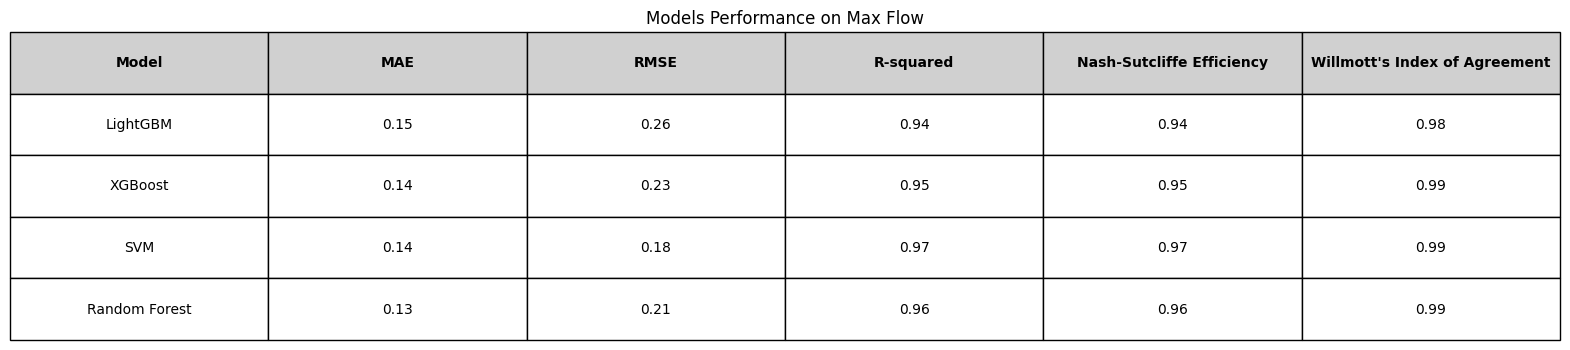

In [313]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Max Flow')
plt.show()


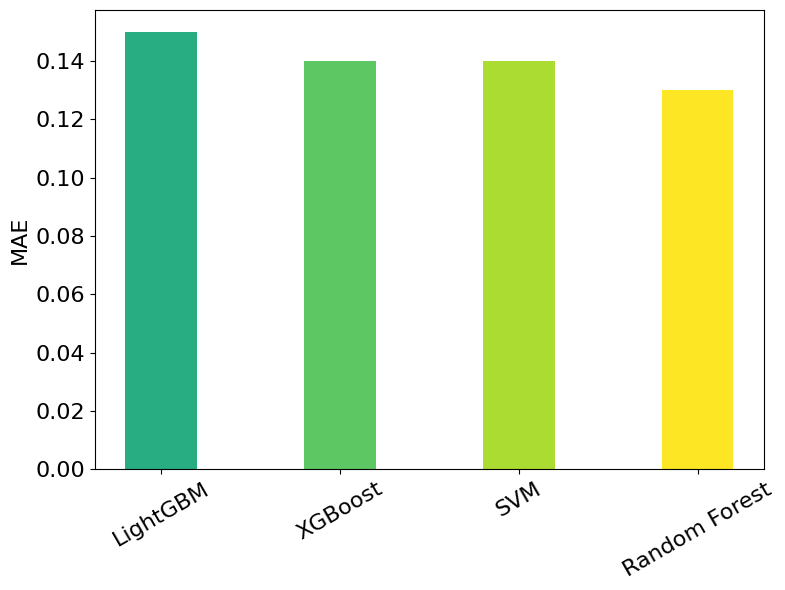

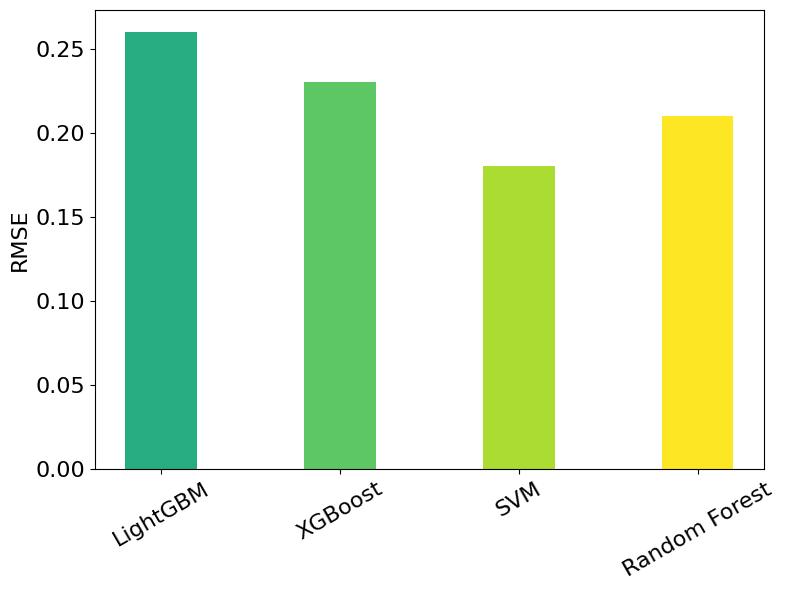

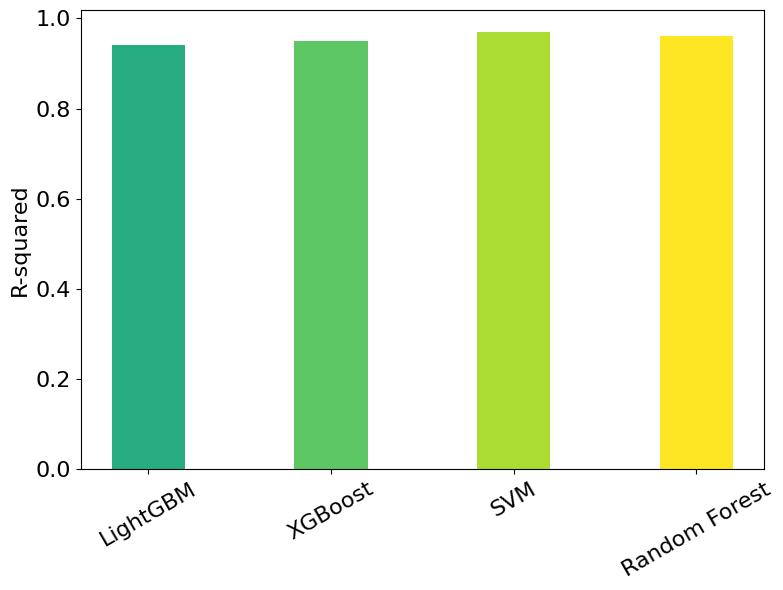

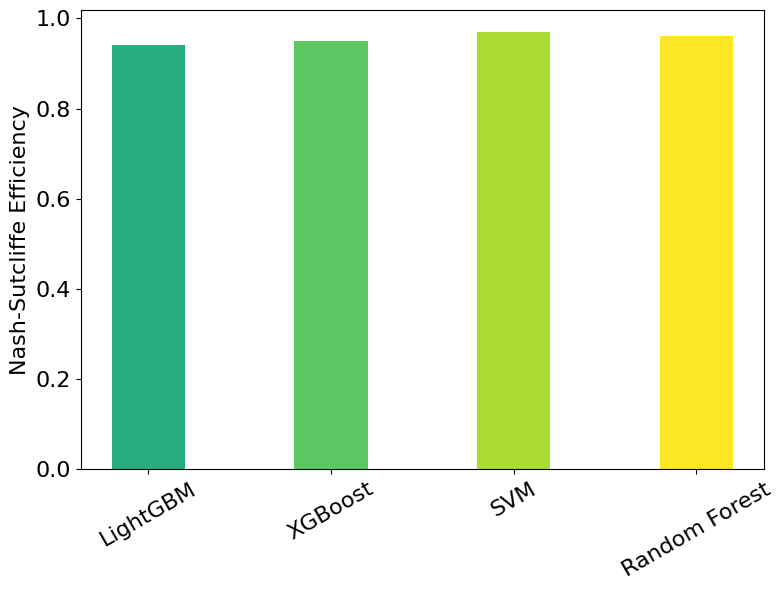

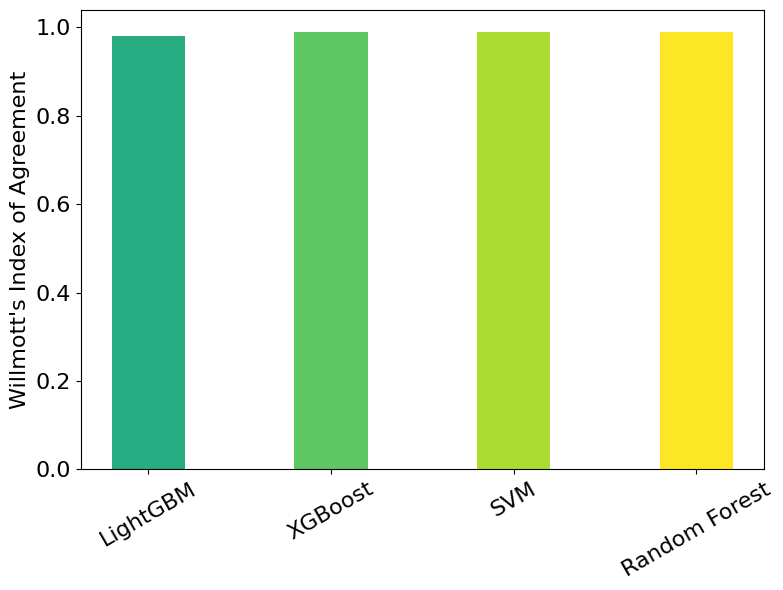

In [314]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

## 9. MIN FLOW ANALYSIS

In [315]:
flow_min = transformed_data[transformed_data['Parameter']=='Min Flow']

In [316]:
# drop the parameter columns
flow_min = flow_min.drop(columns=['Parameter'])

In [317]:
flow_min.head()

Date  Value
3  1995-01-01  0.212
8  1996-01-01  0.070
13 1997-01-01  0.169
18 1998-01-01  0.274
23 1999-01-01  0.116

In [318]:
# sort according to  the date
flow_min = flow_min.sort_values(by='Date')
flow_min.head()

Date  Value
3   1995-01-01  0.212
138 1995-02-01  0.223
273 1995-03-01  0.212
408 1995-04-01  0.200
543 1995-05-01  0.235

In [319]:
flow_min.head()

Date  Value
3   1995-01-01  0.212
138 1995-02-01  0.223
273 1995-03-01  0.212
408 1995-04-01  0.200
543 1995-05-01  0.235

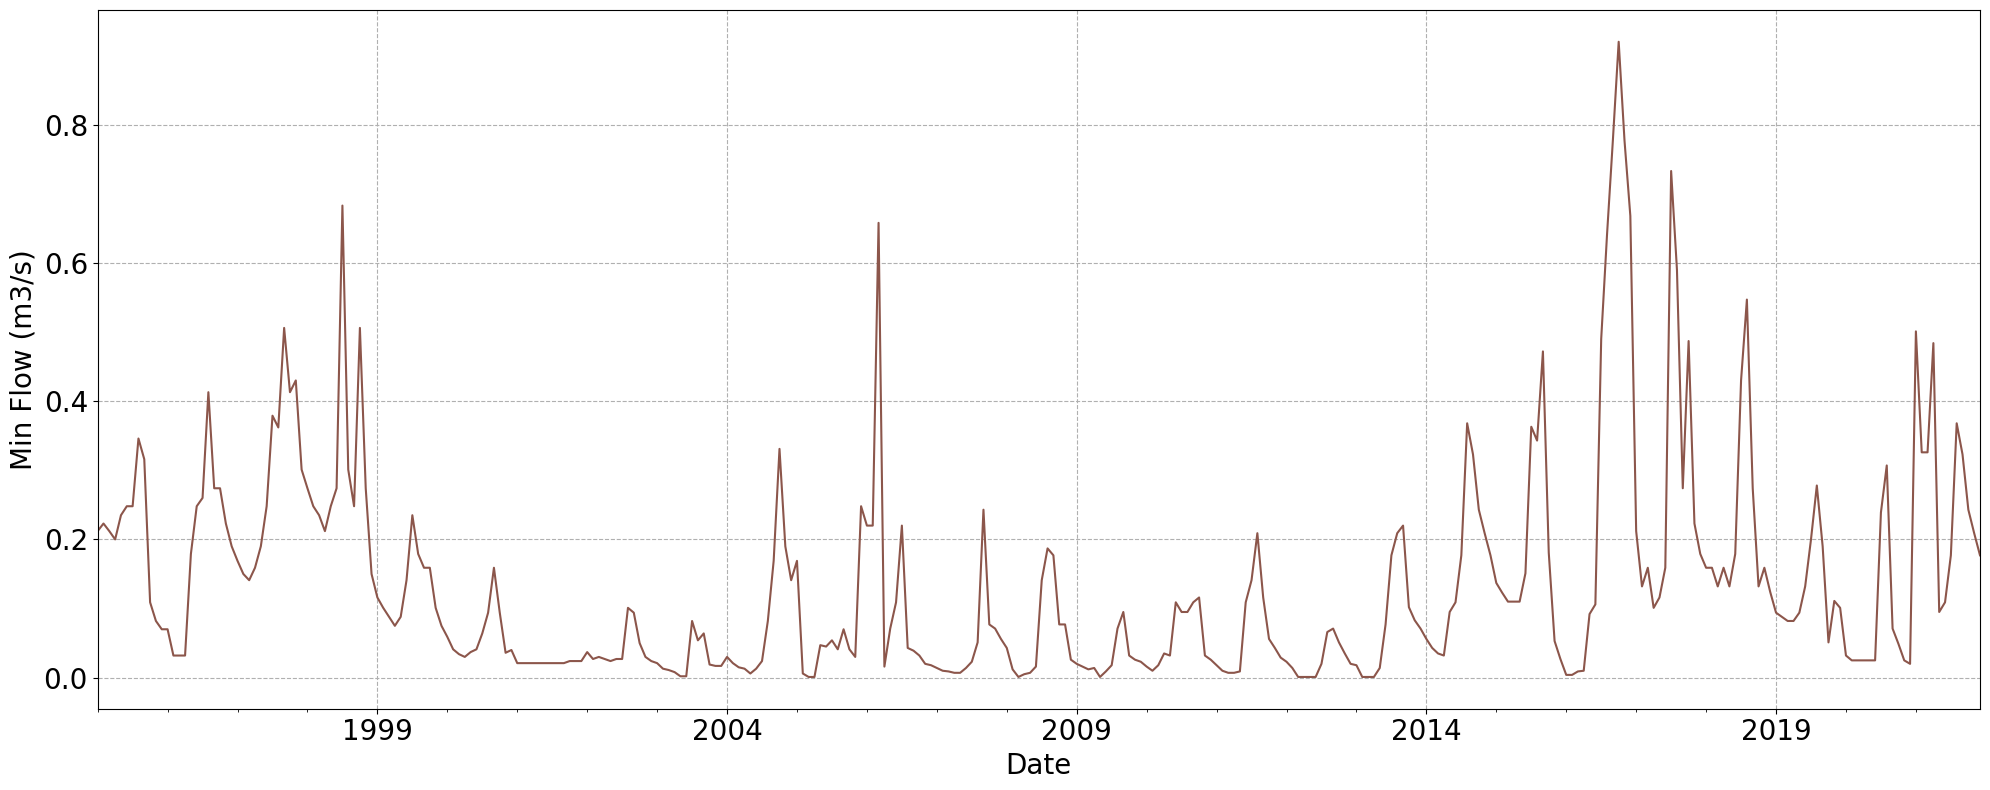

In [320]:
plt.figure(figsize=(20, 8))
flow_min.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#8c564b', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Min Flow (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [321]:
flow_min[flow_min.Value > 1]

Empty DataFrame
Columns: [Date, Value]
Index: []

In [322]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [323]:
# H0: It is non stationary
# H1: It is stationary

In [324]:
adfuller_test(flow_min['Value'])

ADF Test Statistic : -2.3097085744112578
p-value : 0.16885587943215408
#Lags Used : 13
Number of Observations Used : 310
Weak evidence against the null hypothesis(H0)


In [325]:
flow_min = flow_min[['Date', 'Value']]
flow_min.set_index('Date', inplace=True)
flow_min.head()

Value
Date             
1995-01-01  0.212
1995-02-01  0.223
1995-03-01  0.212
1995-04-01  0.200
1995-05-01  0.235

In [326]:
flow_min_model_names = []
flow_min_mae_values = []
flow_min_rmse_values = []
flow_min_r2_values = []
flow_min_nse_values = []
flow_min_willmott_values = []

### TRAIN THE MODEL

In [327]:
# Assuming `flow min` is your time series DataFrame
series = flow_min
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=-0.7, predicted=-0.5
>expected=-0.4, predicted=-0.5
>expected=0.0, predicted=0.5
>expected=0.3, predicted=0.7
>expected=-0.1, predicted=0.0
>expected=0.9, predicted=0.4
>expected=0.3, predicted=0.4
>expected=-0.3, predicted=-0.3
>expected=-0.1, predicted=-0.3
>expected=-0.2, predicted=-0.3
>expected=-0.7, predicted=-0.8
>expected=-0.8, predicted=-0.8
>expected=-0.8, predicted=-0.7
>expected=-0.8, predicted=-0.7
>expected=1.1, predicted=0.5
>expected=1.4, predicted=0.8
>expected=1.0, predicted=0.9
>expected=1.3, predicted=0.5
>expected=-0.4, predicted=0.2
>expected=-0.5, predicted=-0.4
>expected=3.3, predicted=0.7
>expected=2.8, predicted=2.3
>expected=0.7, predicted=2.6
>expected=0.6, predicted=1.1
>expected=2.1, predicted=0.7
>expected=2.5, predicted=1.3
>expected=-0.1, predicted=-0.1
>expected=1.2, predicted=0.9
>expected=0.7, predicted=1.6
>expected=0.2, predicted=1.0
>expected=0.1, predicted=0.6
>expected=-0.3, predicted=0.0
>expected=-0.7, predicted=-0.4
>expected=-0.4, 

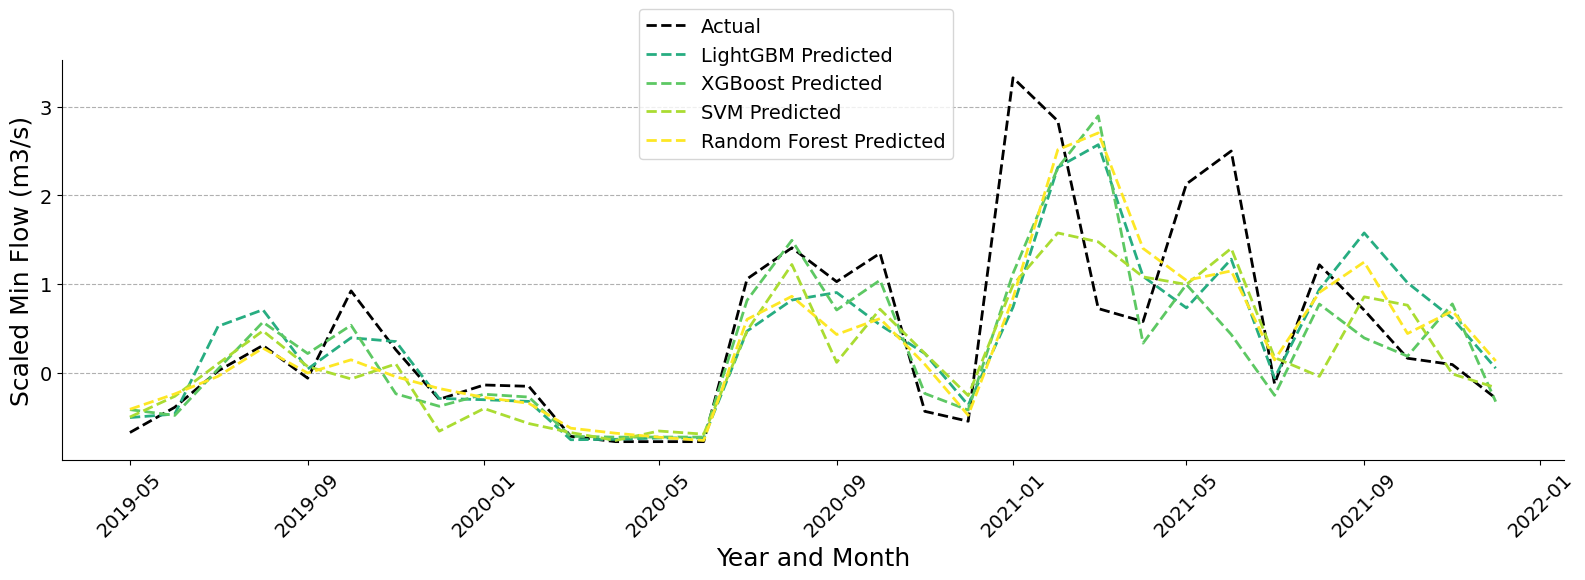

In [328]:
# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Min Flow (m3/s)', fontsize=18)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.6, 1.15), ncol=1)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [329]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}
metrics = pd.DataFrame(metrics)

In [330]:
metrics

Model       MAE      RMSE  R-squared  Nash-Sutcliffe Efficiency  \
0       LightGBM  0.510560  0.764473   0.494032                   0.494032   
1        XGBoost  0.422930  0.735053   0.532226                   0.532226   
2            SVM  0.500558  0.709194   0.564559                   0.564559   
3  Random Forest  0.466310  0.770881   0.485514                   0.485514   

   Willmott's Index of Agreement  
0                       0.814135  
1                       0.836220  
2                       0.831898  
3                       0.833792

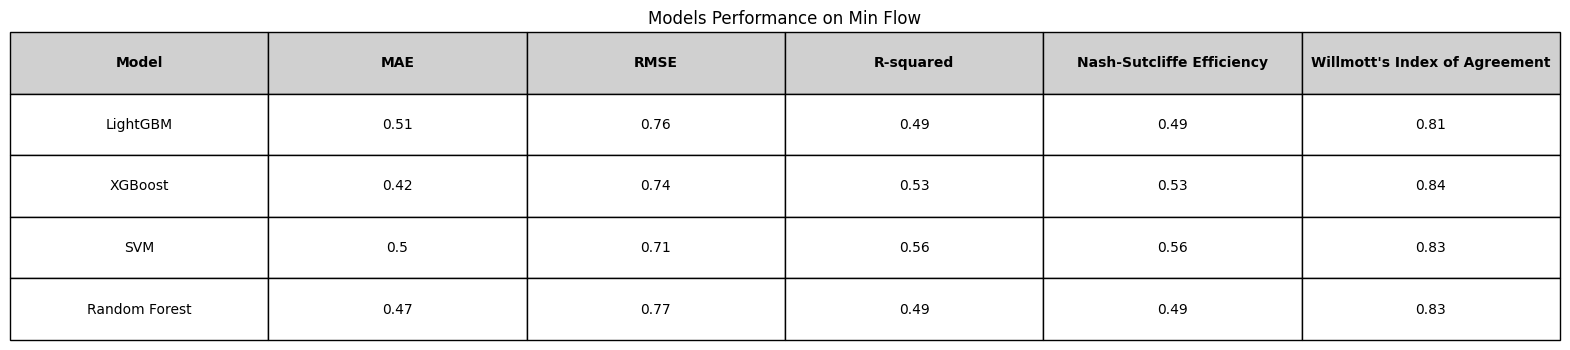

In [331]:
metrics = metrics.round(2)
fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Min Flow')
plt.show()

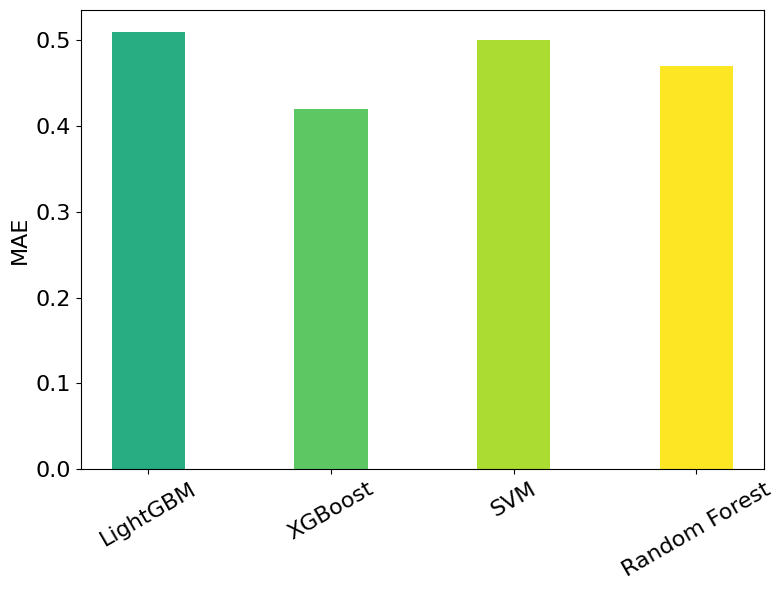

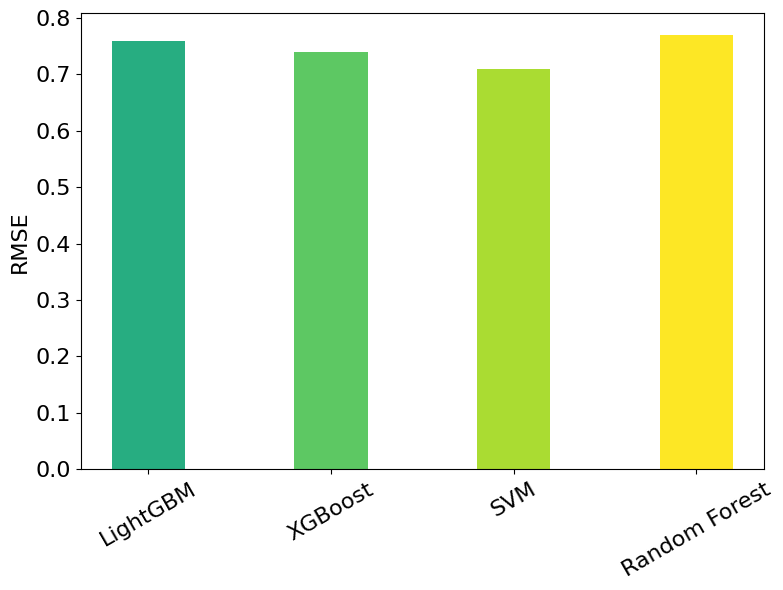

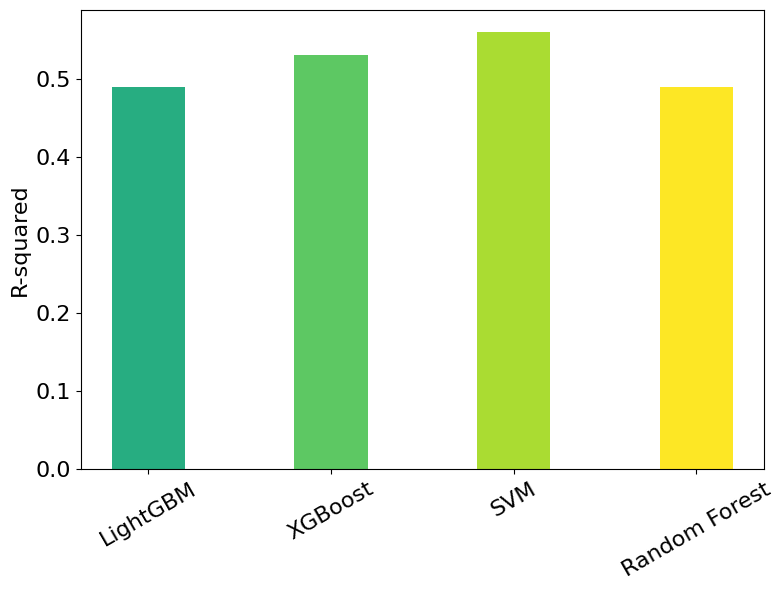

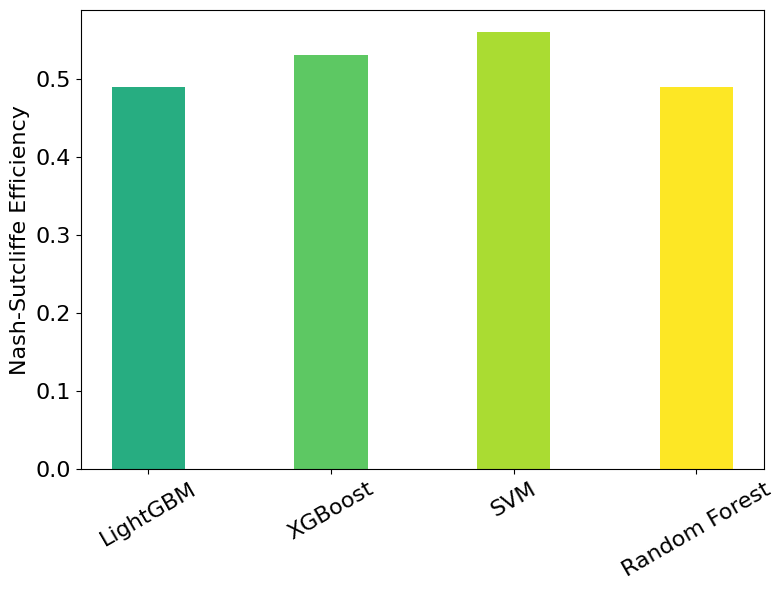

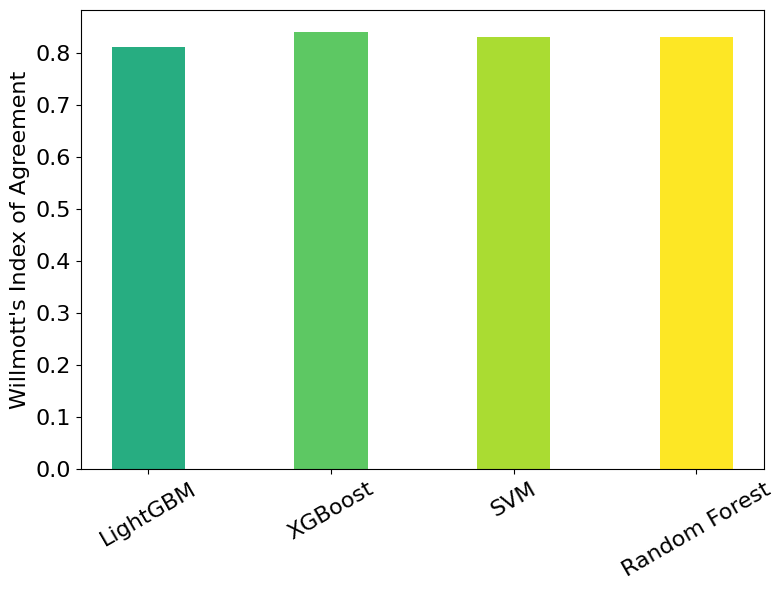

In [332]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

## 10. RUNOFF (m3/s) ANALYSIS

In [333]:
# Get the wind_min values
runoff = transformed_data[transformed_data['Parameter'] == parameters[4]]
runoff.head()

Parameter       Date     Value
4     Runoff 1995-01-01  1.658000
9     Runoff 1996-01-01  1.095387
14    Runoff 1997-01-01  1.856000
19    Runoff 1998-01-01  1.930000
24    Runoff 1999-01-01  9.392000

In [334]:
# drop the parameter columns
runoff = runoff.drop(columns=['Parameter'])

In [335]:
runoff.head()

Date     Value
4  1995-01-01  1.658000
9  1996-01-01  1.095387
14 1997-01-01  1.856000
19 1998-01-01  1.930000
24 1999-01-01  9.392000

In [336]:
# sort according to  the date
runoff = runoff.sort_values(by='Date')
runoff.head()

Date  Value
4   1995-01-01  1.658
139 1995-02-01  1.158
274 1995-03-01  1.861
409 1995-04-01  1.554
544 1995-05-01  2.298

In [337]:
runoff.head()

Date  Value
4   1995-01-01  1.658
139 1995-02-01  1.158
274 1995-03-01  1.861
409 1995-04-01  1.554
544 1995-05-01  2.298

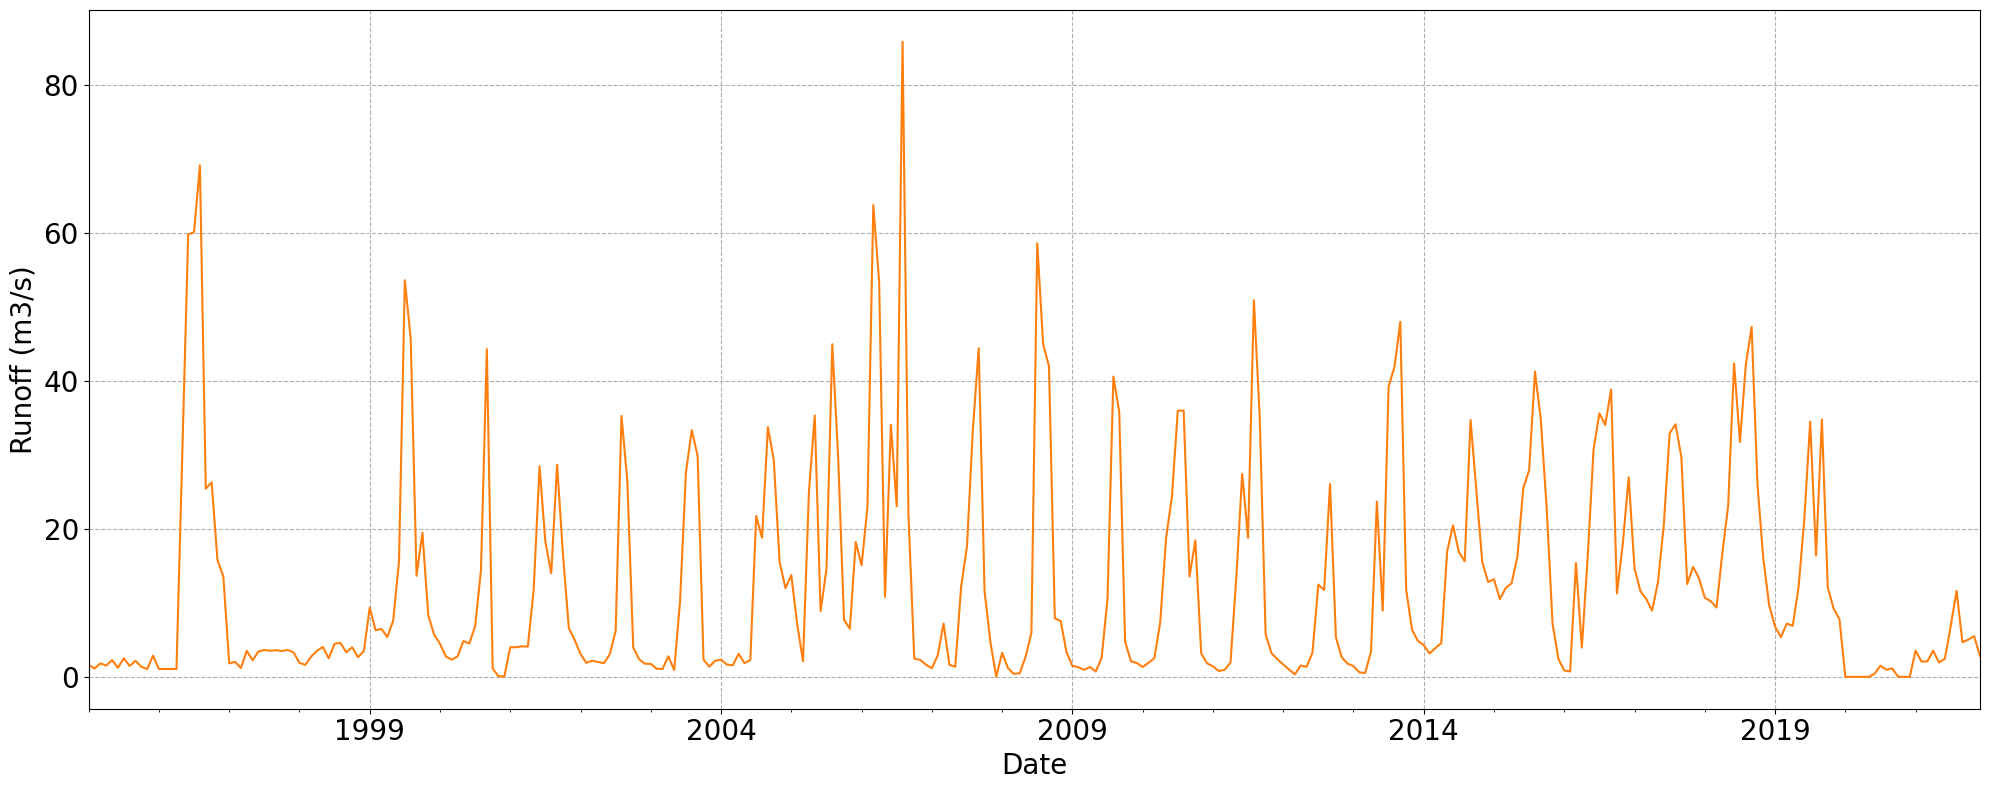

In [338]:
plt.figure(figsize=(20, 8))
runoff.plot(x='Date', y='Value', kind='line', ax=plt.gca(), color='#ff7f0e', fontsize=12)
plt.xlabel('Date', fontdict={'fontsize':20})
plt.ylabel('Runoff (m3/s)', fontdict={'fontsize':20})
plt.xticks(size = 20)
plt.yticks(size = 20)
plt.grid(linestyle='--')
plt.tight_layout()
plt.legend().remove()
plt.show()

In [339]:
# Add fuller test to check the stationarity of the dataset
def adfuller_test(values):
    result = adfuller(values)
    labels = ['ADF Test Statistic','p-value','#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(H0)")
    else:
        print("Weak evidence against the null hypothesis(H0)")

In [340]:
# H0: It is non stationary
# H1: It is stationary

In [341]:
adfuller_test(runoff['Value'])

ADF Test Statistic : -4.186222397590971
p-value : 0.0006951911057647956
#Lags Used : 13
Number of Observations Used : 310
Strong evidence against the null hypothesis(H0)


In [342]:
runoff = runoff[['Date', 'Value']]
runoff.set_index('Date', inplace=True)
runoff.head()

Value
Date             
1995-01-01  1.658
1995-02-01  1.158
1995-03-01  1.861
1995-04-01  1.554
1995-05-01  2.298

In [343]:
runoff_model_names = []
runoff_mae_values = []
runoff_rmse_values = []
runoff_r2_values = []
runoff_nse_values = []
runoff_willmott_values = []

### TRAIN THE MODEL

In [344]:
# Assuming `runoff` is your time series DataFrame
series = runoff
values = series.values
values = add_rolling_features(values, window=3)
values = pd.DataFrame(values).values
scaler = StandardScaler()
values = scaler.fit_transform(values)
data = series_to_supervised(values, n_in=6)
data_df = pd.DataFrame(data, index=series.index[6+2:])

>expected=-0.5, predicted=-0.4
>expected=0.1, predicted=-0.0
>expected=0.6, predicted=0.7
>expected=0.4, predicted=-0.0
>expected=0.5, predicted=0.3
>expected=0.7, predicted=0.5
>expected=1.0, predicted=0.8
>expected=-0.6, predicted=-0.1
>expected=-0.2, predicted=-0.6
>expected=-0.3, predicted=-0.6
>expected=-0.9, predicted=-0.7
>expected=-0.9, predicted=-0.8
>expected=-0.9, predicted=-0.7
>expected=-0.9, predicted=-0.6
>expected=-0.8, predicted=-0.7
>expected=-0.8, predicted=-0.5
>expected=-0.8, predicted=-0.6
>expected=-0.8, predicted=-0.7
>expected=-0.8, predicted=-0.7
>expected=-0.9, predicted=-0.7
>expected=-0.6, predicted=-0.6
>expected=-0.6, predicted=-0.6
>expected=-0.8, predicted=-0.6
>expected=-0.8, predicted=-0.7
>expected=-0.8, predicted=-0.8
>expected=-0.8, predicted=-0.7
>expected=-0.5, predicted=-0.7
>expected=-0.3, predicted=-0.3
>expected=-0.4, predicted=-0.3
>expected=-0.4, predicted=-0.5
>expected=-0.8, predicted=-0.5
>expected=-0.7, predicted=-0.8
>expected=-0.5, pr

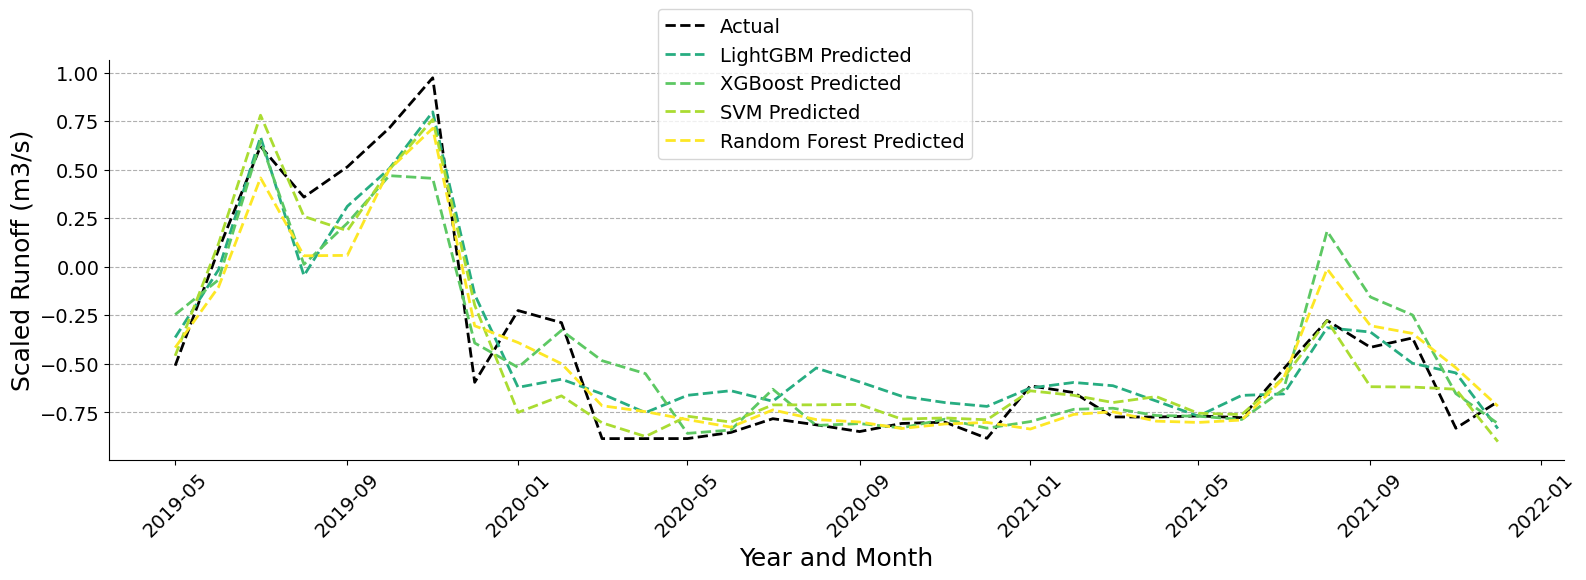

In [345]:

# Model names
models = [
    ('LightGBM', lightgbm_forecast),
    ('XGBoost', xgboost_forecast),
    ('SVM', svm_forecast),
    ('Random Forest', random_forest_forecast)
]

# Clear existing lists in case they contain previous values
model_names.clear()
mae_values.clear()
rmse_values.clear()
r2_values.clear()
nse_values.clear()
willmott_values.clear()

# Iterate over each model, perform walk-forward validation, and append metrics to lists
for model_name, model_func in models:
    mae, rmse, r2, nse, willmott, test_index, y, yhat = walk_forward_validation(data_df, model_func)
    
    model_names.append(model_name)
    mae_values.append(mae)
    rmse_values.append(rmse)
    r2_values.append(r2)
    nse_values.append(nse)
    willmott_values.append(willmott)

# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics_df = pd.DataFrame(metrics)

# Plot the actual vs predicted values for each model
plt.figure(figsize=(16, 6))
plt.plot(test_index, y, label='Actual', linestyle='--', color='black', linewidth=2)



for model_name, model_func in models:
    _, _, _, _, _, test_index, _, yhat = walk_forward_validation(data_df, model_func)
    plt.plot(test_index, yhat, label=f'{model_name} Predicted', linestyle='--', color=colors_dict[model_name], linewidth=2)

plt.xlabel('Year and Month', fontsize=18)
plt.ylabel('Scaled Runoff (m3/s)', fontsize=18)

plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(0.6, 1.15), ncol=1)

plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

plt.grid(axis='y', linestyle='--')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### EVALUATE THE MODEL

In [346]:
# Create a DataFrame
metrics = {
    'Model': model_names,
    'MAE': mae_values,
    'RMSE': rmse_values,
    'R-squared': r2_values,
    'Nash-Sutcliffe Efficiency': nse_values,
    'Willmott\'s Index of Agreement': willmott_values
}

metrics = pd.DataFrame(metrics)

In [347]:
metrics

Model       MAE      RMSE  R-squared  Nash-Sutcliffe Efficiency  \
0       LightGBM  0.171717  0.204025   0.848730                   0.848730   
1        XGBoost  0.156541  0.212774   0.835479                   0.835479   
2            SVM  0.133483  0.184586   0.876182                   0.876182   
3  Random Forest  0.131083  0.173587   0.890499                   0.890499   

   Willmott's Index of Agreement  
0                       0.952940  
1                       0.949176  
2                       0.965221  
3                       0.966709

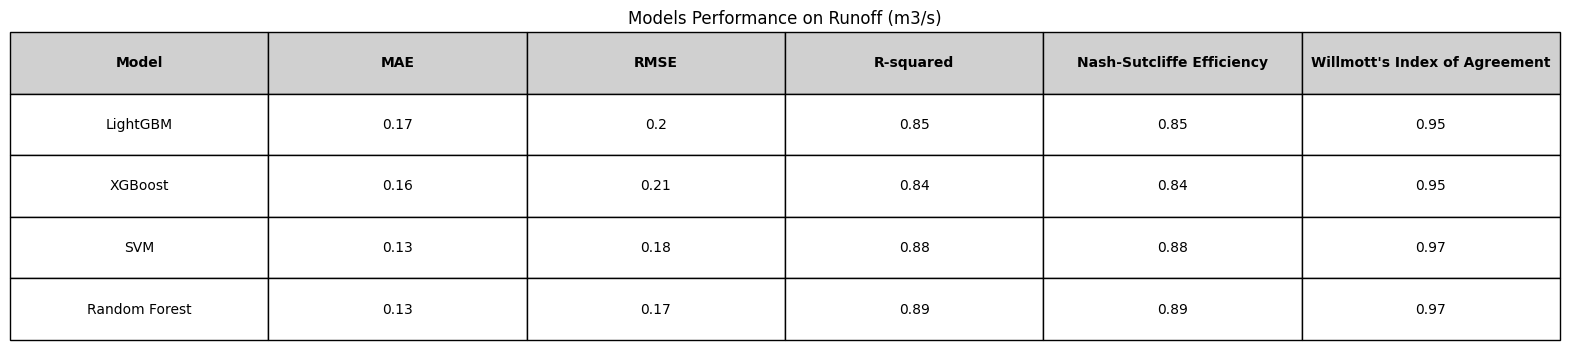

In [348]:
metrics = metrics.round(2)

fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')

table = ax.table(cellText=metrics.values,
                 colLabels=metrics.columns,
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

header_color = '#D0D0D0'
data_color = '#FFFFFF'

for i, key in enumerate(table._cells):
    cell = table._cells[key]
    cell.set_edgecolor('black')
    if key[0] == 0 or key[1] == -1:
        cell.set_text_props(weight='bold')
        cell.set_facecolor(header_color)
    else:
        cell.set_facecolor(data_color)

plt.title('Models Performance on Runoff (m3/s)')
plt.show()


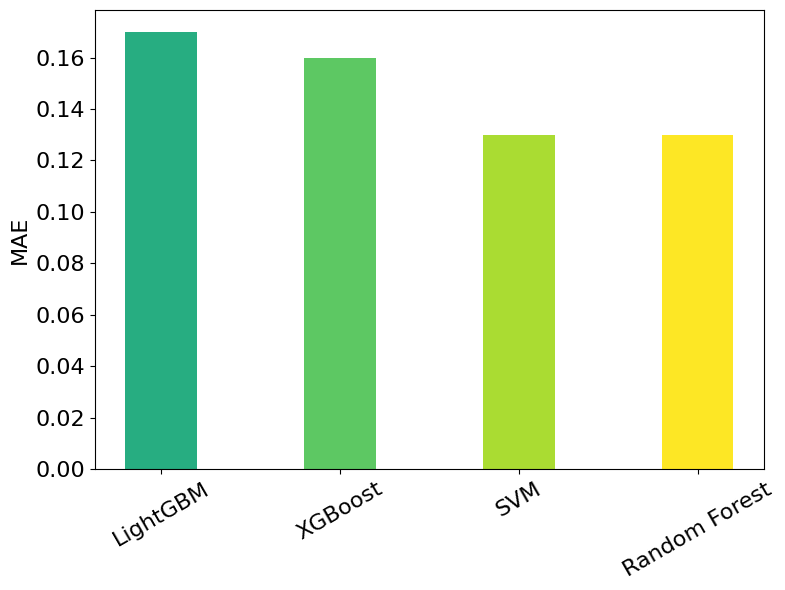

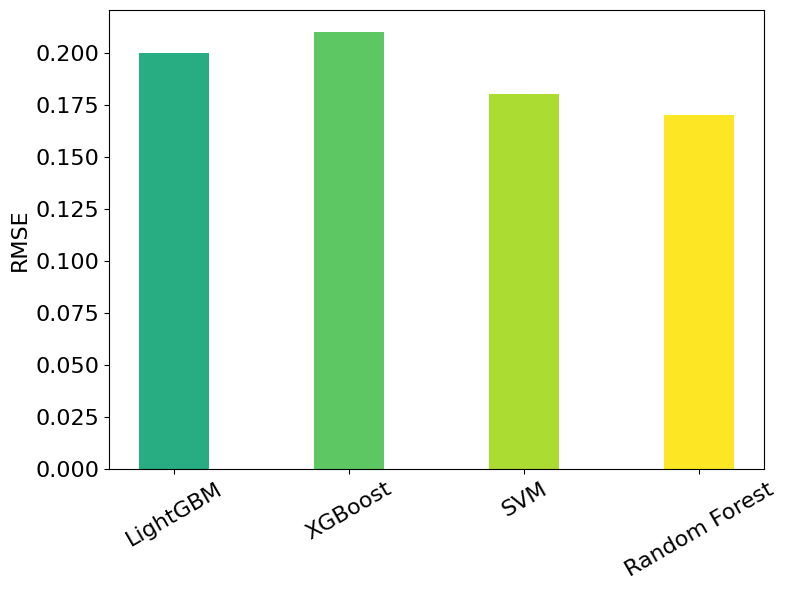

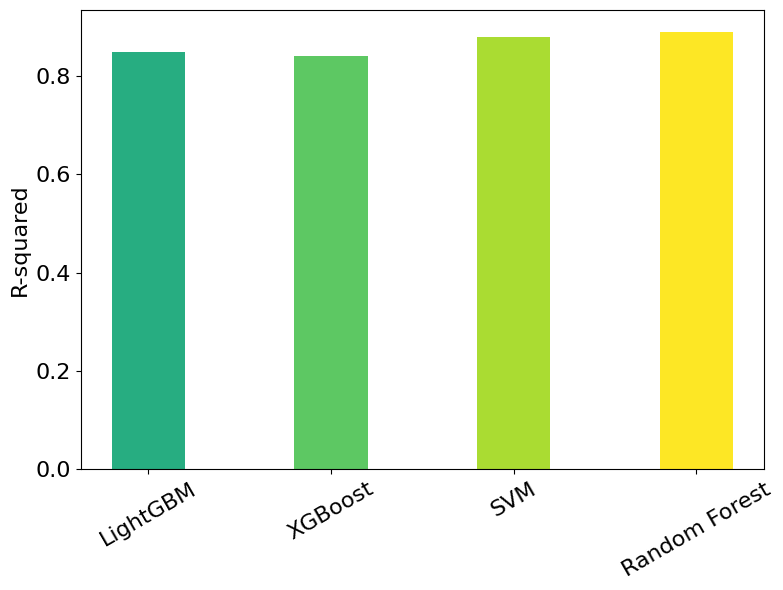

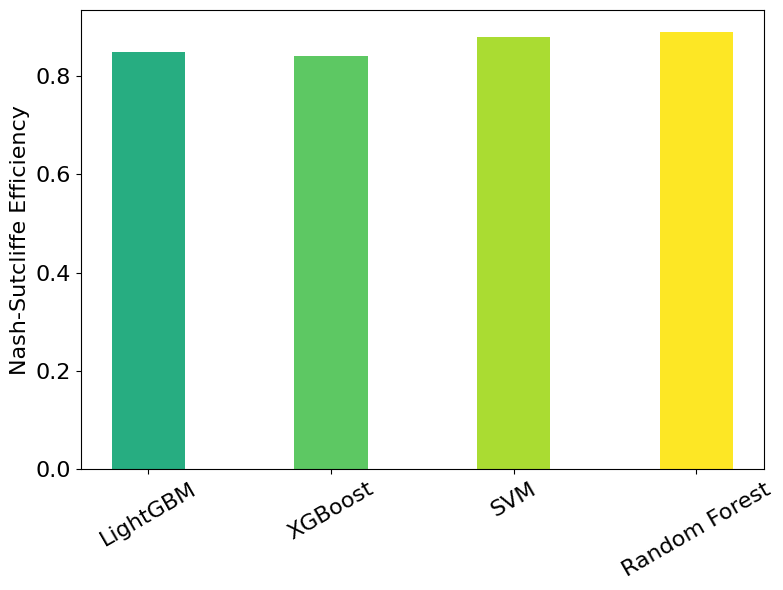

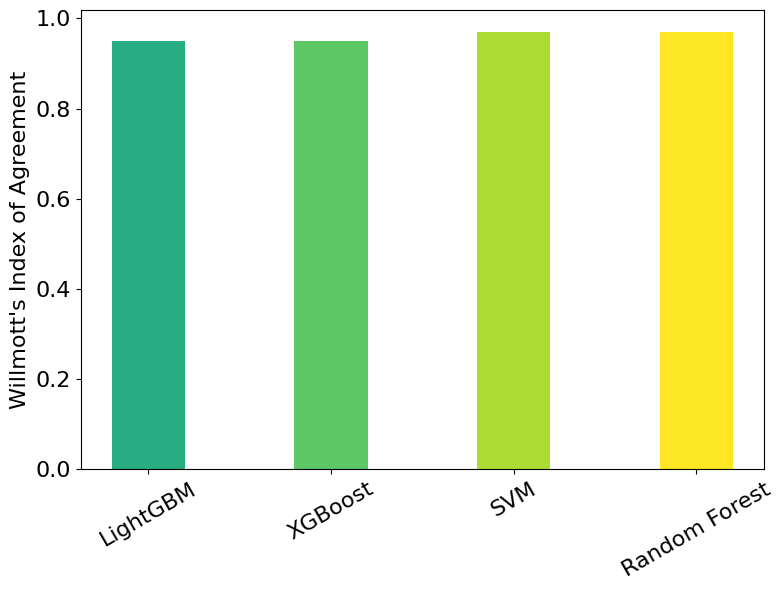

In [349]:

colors = ['#27ad81', '#5dc863', '#aadc32', '#fde725']
bar_width = 0.4

# Metrics and Titles
metrics_title = {
    'MAE': 'Mean Absolute Error (MAE)',
    'RMSE': 'Root Mean Squared Error (RMSE)',
    'R-squared': 'R-squared',
    'Nash-Sutcliffe Efficiency': 'Nash-Sutcliffe Efficiency',
    'Willmott\'s Index of Agreement': 'Willmott\'s Index of Agreement'
}

# Plot each metric separately
for metric, title in metrics_title.items():
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(metrics['Model'], metrics[metric], color=colors, width=bar_width)
    # ax.set_title(title, fontsize=16)
    ax.set_ylabel(metric, fontsize=16)
    ax.tick_params(axis='x', rotation=30, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    plt.tight_layout()
    plt.show()

### The End